Import libraries

In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import to_hex
from pathlib import Path
import seaborn as sns
from datetime import datetime
import matplotlib.gridspec as gridspec
plt.style.use('default')
from src import analyse as an

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Select folder

In [3]:
today = datetime.today().strftime('%Y-%m-%d')
#path = Path(r'\\nasdcsr.unil.ch\RECHERCHE\FAC\FBM\CIG\jlarsch\default\D2c\Matilde\behavior')
path = Path(r'/Volumes/LAB-MATI/Lausanne/behavior')

date = path / '2025.02.20'

# path for saving figures
path_figures = path / rf'plots\{today}\exp_{date.name}'
path_figures.mkdir(parents=True, exist_ok=True)

#load stimuli files
stimuli_df = pd.read_csv(next(date.glob("*trajectory*.csv")), header=None)
experiment = next(date.glob("*trajectory*.csv")).name.split('_')[2]
stimuli_df_col_names = ["name", "x", "y", "size", "color", "backg"]
n_stimuli = len(stimuli_df.columns)//len(stimuli_df_col_names)
stimuli_df.columns = stimuli_df_col_names * n_stimuli

#load fish files
df = pd.read_csv(next(date.glob("*PositionTxt*.csv")), sep=r" ", header=None )
n_fish = len(df.columns)//3 - n_stimuli
fish_columns = [f"f{i}_{var}" for i in range(n_fish) for var in ["x", "y", "ori"]]
stimuli_columns = [f"d{i}_{var}" for i in range(n_stimuli) for var in ["x", "y", "stim"]]
df.columns = fish_columns + stimuli_columns

#load roi file
roi_df = pd.read_csv(next(date.glob("ROI*.csv")), header=None)
roi_columns = ["xoff", "yoff", "diameter", "x", "y", "radius"]
roi_df.columns = roi_columns

#### Sanity check that everything matches

Check that stimuli df and df_fish have the same number of rows

Check that stimuli df and df_fish[stimuli_columns] have the same values in name/stim


In [4]:
# Select only columns containing x, y, and name
stimuli_df = stimuli_df.drop(columns=['size', 'color', 'backg'])

# Rename columns to match the desired format
new_column_names = [col for i in range(n_stimuli) for col in (f'd{i}_stim', f'd{i}_x', f'd{i}_y')]
stimuli_df.columns = new_column_names

# Reorder columns to match the desired structure
ordered_columns = [col for i in range(n_stimuli) for col in (f'd{i}_x', f'd{i}_y', f'd{i}_stim')]
stimuli_df = stimuli_df[ordered_columns]

In [5]:
stim_columns = [f"d{i}_stim" for i in range(n_stimuli)]
all_true = (df[stim_columns] == stimuli_df[stim_columns]).all().all()

if all_true:
    print("All stimuli values between PositionTxt and trajectory files match")
else:
    print("Some stimuli values between PositionTxt and trajectory files do not match. \n"
          "ATTENTION!!!")

All stimuli values between PositionTxt and trajectory files match


#### Extract parameters of the Experiment


In [6]:
# 1. Calculate the duration of the initial pause
framerate = 30
PX_TO_MM = 3.67
avgROIRadius = round(roi_df['radius'].mean())

# Identify key indices
start_interpause_idx = (df["d0_stim"] == "none").idxmax()
CLstimuli_mask = df["d0_stim"].str.startswith("CLsemi", na=False)
CLstimuli_start_idx = CLstimuli_mask.idxmax()
CLstimuli_end_idx = CLstimuli_mask[CLstimuli_start_idx:].idxmin()

# Compute durations
CLstimuli_duration = (CLstimuli_end_idx - CLstimuli_start_idx) // framerate
post_stim_pause_start = (df.loc[CLstimuli_end_idx:]["d0_stim"] == "none").idxmin()
inter_pause_duration = (post_stim_pause_start - CLstimuli_end_idx) / framerate

initial_pause = (df["d0_stim"] == "start_none").idxmin() / framerate
bout_duration = len(df.loc[df["d0_stim"] == "bout"])//framerate

n_trials_tot = len(df.index[(df['d0_stim'] != "none") & (df['d0_stim'].shift(1) == "none")])
experimental_conditions = [val for val in df["d0_stim"].unique() if val.startswith("CLsemi")]
n_trials_per_condition = n_trials_tot // len(experimental_conditions)

# Make a nice print that describe and summarize the experiment
print(f"Experiment: {date.name}")
print(f"Experiment type: {experiment}")
print(f"Initial pause: {initial_pause/60} min")
print(f"Interstimulus pause: {inter_pause_duration} s")
print(f"CLstimuli duration: {CLstimuli_duration} s")
print(f"Bout duration: {bout_duration/60} min")
print(f"Number of trials: {n_trials_tot}")
print(f"Number of trials per condition: {n_trials_per_condition}")
print(f"{len(experimental_conditions)} experimental conditions:{experimental_conditions}")

Experiment: 2025.02.20
Experiment type: GsizeMotionSingle
Initial pause: 0.0 min
Interstimulus pause: 50.0 s
CLstimuli duration: 60 s
Bout duration: 5.0 min
Number of trials: 96
Number of trials per condition: 6
16 experimental conditions:['CLsemi1800_g4-0_s3.5-3.5', 'CLsemi1800_g0-2_s3.5-3.5', 'CLsemi1800_g0-4_s3.5-3.5', 'CLsemi1800_g8-0_s3.5-3.5', 'CLsemi1800_g0-4_s0-0', 'CLsemi1800_g8-0_s0-0', 'CLsemi1800_g6-0_s3.5-3.5', 'CLsemi1800_g0-8_s0-0', 'CLsemi1800_g1-0_s3.5-3.5', 'CLsemi1800_g0-1_s3.5-3.5', 'CLsemi1800_g2-0_s3.5-3.5', 'CLsemi1800_g0-8_s3.5-3.5', 'CLsemi1800_g0-6_s3.5-3.5', 'CLsemi1800_g4-0_s0-0', 'CLsemi1800_g0-1_s0-0', 'CLsemi1800_g1-0_s0-0']


Divide dataframes

In [7]:
#remove initial pause
df["condition"] = np.where(df["d0_stim"] == "none", "inter_stim_pause", df["d0_stim"])

#save bout data separately and remove from main data
bout_df = df.loc[df["d0_stim"] == "bout"].copy()
bout_df = bout_df.drop(columns=stimuli_columns)
stimuli_bout_df = stimuli_df.loc[stimuli_df["d0_stim"] == "bout"].copy()
stimuli_bout_df = stimuli_bout_df[['d0_x', 'd0_y', 'd0_stim']]
stimuli_bout_df = stimuli_bout_df.round(3)
stimuli_bout_df["condition"] = bout_df["condition"]

df_selected = df.loc[(CLstimuli_start_idx - int(inter_pause_duration*framerate)):].copy()
fish_df = df_selected.loc[df["d0_stim"] != "bout"].copy()
fish_df = fish_df.drop(columns=stimuli_columns)
stimuli_fish_df = stimuli_df.loc[(CLstimuli_start_idx - int(inter_pause_duration*framerate)):].copy()
stimuli_fish_df = stimuli_fish_df.loc[stimuli_fish_df["d0_stim"] != "bout"]
stimuli_fish_df["condition"] = fish_df["condition"]

Extract information about trial and stimulus block start

In [8]:
# fish_df['trial_start'] = (fish_df['condition'] != "inter_stim_pause") & (fish_df['condition'].shift(1) == "inter_stim_pause")

fish_df['trial_start'] = (fish_df['condition'] == "inter_stim_pause") & (fish_df['condition'].shift(1) != "inter_stim_pause")
fish_df['trial_id'] = fish_df['trial_start'].cumsum()

fish_df = fish_df.copy()
fish_df['stimulus_block_id'] = (fish_df['condition'] != fish_df['condition'].shift(1)).cumsum()
fish_df['frame_count_stimulus'] = fish_df.groupby('stimulus_block_id').cumcount()
fish_df['frame'] = np.arange(0, len(fish_df))

stimuli_fish_df['trial_id'] = fish_df['trial_id']
stimuli_fish_df['stimulus_block_id'] = fish_df['stimulus_block_id']
stimuli_fish_df['frame_count_stimulus'] = fish_df['frame_count_stimulus']
stimuli_fish_df['trial_start'] = fish_df['trial_start']
stimuli_fish_df['frame'] = np.arange(0, len(stimuli_fish_df))

### Transform to coordinates


#### Transform stimuli into absolute pixel coordinates

Copy trajetcory over stimulus pause, for control

In [9]:
dot_xy_cols = [col for col in stimuli_fish_df.columns if col.startswith('d') and ('_x' in col or '_y' in col)]
dot_stim_cols = [col for col in stimuli_fish_df.columns if col.startswith('d') and '_stim' in col]

stimuli_fish_df  = stimuli_fish_df.groupby('trial_id', group_keys=False)[stimuli_fish_df.columns].apply(an.pause_copy_trajectory,
                                                                                        dot_xy_cols=dot_xy_cols,
                                                                                        dot_stim_cols=dot_stim_cols)

In [10]:
mask_left = stimuli_fish_df.filter(like='x').gt(0)
mask_right = stimuli_fish_df.filter(like='x').lt(0)
stimuli_fish_df['n_dots_left'] = mask_left.sum(axis=1)
stimuli_fish_df['n_dots_right'] = mask_right.sum(axis=1)

stimuli_fish_df[stimuli_fish_df.filter(like='x').columns] *= PX_TO_MM
stimuli_fish_df[stimuli_fish_df.filter(like='y').columns] *= PX_TO_MM

stimuli_allfish_dict = {}
for f in range(n_fish):
    abs_trials = []
    for block_id, stim_group in stimuli_fish_df.groupby('stimulus_block_id'):
        # Use the corresponding fish row at trial start (without transformation).
        # (Here, frames_before is 0 as in your code.)
        fish_row = fish_df.loc[stim_group.index[0]]
        trial_abs = an.compute_stimuli_absolute(f, stim_group, fish_row, n_stimuli)
        abs_trials.append(trial_abs)

    stimuli_abs_df = pd.concat(abs_trials)
    extra_cols = stimuli_fish_df.columns[n_stimuli*len(["x", "y", "stim"]):]
    stimuli_abs_df = pd.concat([stimuli_abs_df, stimuli_fish_df[extra_cols]], axis=1)

    stimuli_allfish_dict[f'f{f}'] = stimuli_abs_df

#### Invert y axis and fish orientation to ccw
(needed for matching spaces for following transformations)

In [11]:
fish_df, stimuli_allfish_dict = an.transform_coordinates(fish_df, stimuli_allfish_dict, roi_df)

#### Calculate dots center

In [12]:
stimuli_allfish_dict = an.compute_stimuli_centers(stimuli_allfish_dict, n_stimuli, mask_left, mask_right, experiment)

Calculate how many dots are out of rois


In [13]:
stimuli_allfish_dict = an.calculate_dots_out(stimuli_allfish_dict, n_stimuli, roi_df, experiment, mask_left, mask_right)

#### Rotate fish and stimuli coordinates so that fish orientation is at 0

In [14]:
ego_df = pd.DataFrame()
stim_ego_dict = {}

for f in range(n_fish):
    stim_ego_trials = []
    fish_ego_trials = []
    for trial_id, fish_group in fish_df.groupby('stimulus_block_id'):
        # Get corresponding stimuli rows (make sure indices align)
        stim_group = stimuli_allfish_dict[f'f{f}'].loc[fish_group.index]
        ego_fish, ego_stim = an.rotate_trajectory(f, fish_group, stim_group, n_stimuli, experiment)
        fish_ego_trials.append(ego_fish)
        stim_ego_trials.append(ego_stim)

    ego_df_tmp = pd.concat(fish_ego_trials)
    ego_df = pd.concat([ego_df, ego_df_tmp], axis=1)

    stim_ego_dict[f'f{f}'] = pd.concat(stim_ego_trials)
    stim_ego_dict[f'f{f}'] = pd.concat([stim_ego_dict[f'f{f}'], stimuli_allfish_dict[f'f{f}']], axis=1)

fish_columns = [col for col in fish_df.columns if any(col.startswith(f"f{i}_") for i in range(n_fish))]
fish_df[fish_columns] = fish_df[fish_columns].round(3)
ego_df = pd.concat([ego_df, fish_df], axis=1)

Transform to long format

In [15]:
# List of the columns that need to be melted (f_number x y x_ego y_ego x_rot y_rot theta_adj)
fish_columns = [col for col in ego_df.columns if any(col.startswith(f"f{i}_") for i in range(n_fish))]

# Columns that should remain as is (not melted)
id_columns = ['frame', 'trial_id', 'condition', 'stimulus_block_id', 'frame_count_stimulus', 'trial_start']

# Melting the dataframe
fish_df_long = pd.melt(ego_df, id_vars=id_columns, value_vars=fish_columns,
                  var_name='fish_number', value_name='value')

# # # Extract f_number and corresponding type (x, y, x_ego, etc.)
fish_df_long[['fish_number', 'type']] = fish_df_long['fish_number'].str.extract(r'f(\d{1,2})_(\w+)')
fish_df_long['fish_number'] = fish_df_long['fish_number'].astype(int)

# # Pivot the table so that each type (x, y, etc.) has its own column
fish_df_long = fish_df_long.pivot(index=['fish_number']+id_columns, columns='type', values='value')

fish_df_long.reset_index(inplace=True)
fish_df_long = fish_df_long.rename_axis(None, axis=1)
fish_df_long = fish_df_long.sort_values(by=["fish_number", "frame"])

add stimuli centers columns

In [16]:
compute_center_point = True

dots_columns = ['dots_center_x_abs', 'dots_center_x_ego', 'dots_center_x_rot',
                'dots_center_y_abs', 'dots_center_y_ego', 'dots_center_y_rot', 'dots_out']

# Add each dots_column to fish_df_long by concatenating across all fish
for col in dots_columns:
    fish_df_long[col] = pd.concat(
        [stim_ego_dict[f'f{f}'][col].reset_index(drop=True) for f in range(n_fish)], ignore_index=True)

In [17]:
masks = {'left': fish_df_long['dots_center_x_rot'] < 0,
         'right': fish_df_long['dots_center_x_rot'] > 0}

if compute_center_point:
    for side in ['left', 'right']:
        for coord in ['x', 'y']:
            col_name = f'square_center_{coord}_rot'
            center_val = an.get_average_center(stim_ego_dict, n_stimuli, side=side, coord=coord)
            fish_df_long.loc[masks[side], col_name] = center_val

Compute distance with dots center

In [18]:
fish_df_long['dotsDist'] = an.euclidean_distance(fish_df_long.x, fish_df_long.y, fish_df_long.dots_center_x_abs, fish_df_long.dots_center_y_abs)
fish_df_long['dotsDist_ego'] = an.euclidean_distance(fish_df_long.x_ego, fish_df_long.y_ego, fish_df_long.dots_center_x_ego, fish_df_long.dots_center_y_ego)
fish_df_long['dotsDist_rot'] = an.euclidean_distance(fish_df_long.x_rot, fish_df_long.y_rot, fish_df_long.dots_center_x_rot, fish_df_long.dots_center_y_rot)

fish_df_long['squareDist_rot'] = an.euclidean_distance(fish_df_long.x_rot, fish_df_long.y_rot, fish_df_long.square_center_x_rot, fish_df_long.square_center_y_rot)

fish_df_long['stim_side'] = 'R'  # Default value
fish_df_long.loc[fish_df_long['dots_center_x_rot'] < 0, 'stim_side'] = 'L'
fish_df_long['stimulus'] = fish_df_long['condition'].apply(an.convert_label, experiment_type=experiment)
fish_df_long = fish_df_long.groupby(['fish_number', 'trial_id'], group_keys=False)[fish_df_long.columns].apply(an.assign_first_choice2, experiment_type=experiment)
fish_df_long["condition_grouped"] = fish_df_long["condition"].apply(an.group_condition_name)

#### General descriptive plots

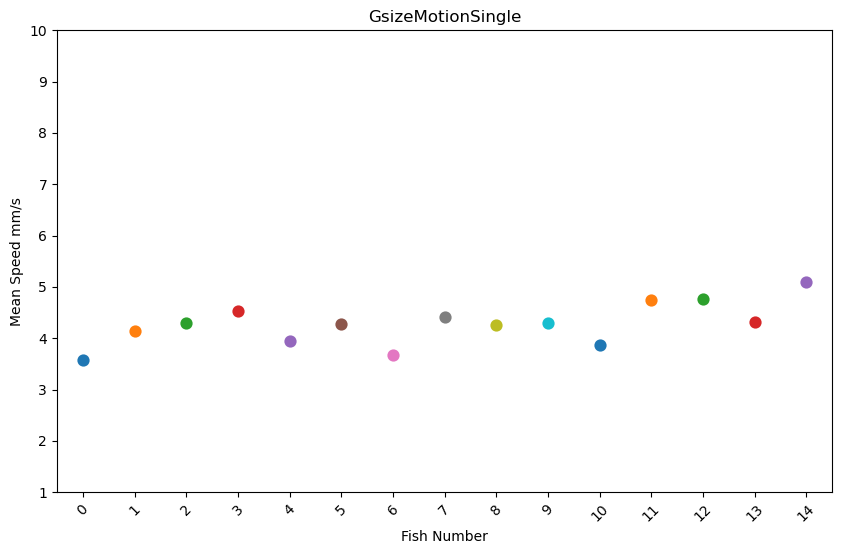

In [19]:
# Compute Euclidean distance between consecutive frames
x_shift = fish_df_long.groupby('fish_number')['x'].diff()
y_shift = fish_df_long.groupby('fish_number')['y'].diff()
fish_df_long['speed'] = np.sqrt(x_shift**2 + y_shift**2)

# Scale speed by the frame rate and conversion factor
fish_df_long['scaled_speed'] = fish_df_long['speed'] * framerate / PX_TO_MM

# Compute mean and standard error for each fish
summary_df = fish_df_long.groupby('fish_number')['scaled_speed'].agg(['mean', 'sem']).reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.pointplot(data=summary_df, x='fish_number', y='mean', palette='tab10', hue='fish_number', capsize=0.2, legend=False)
plt.title(experiment)
plt.xlabel("Fish Number")
plt.ylabel("Mean Speed mm/s")
plt.ylim(1, 10)
plt.xticks(rotation=45)
plt.show()

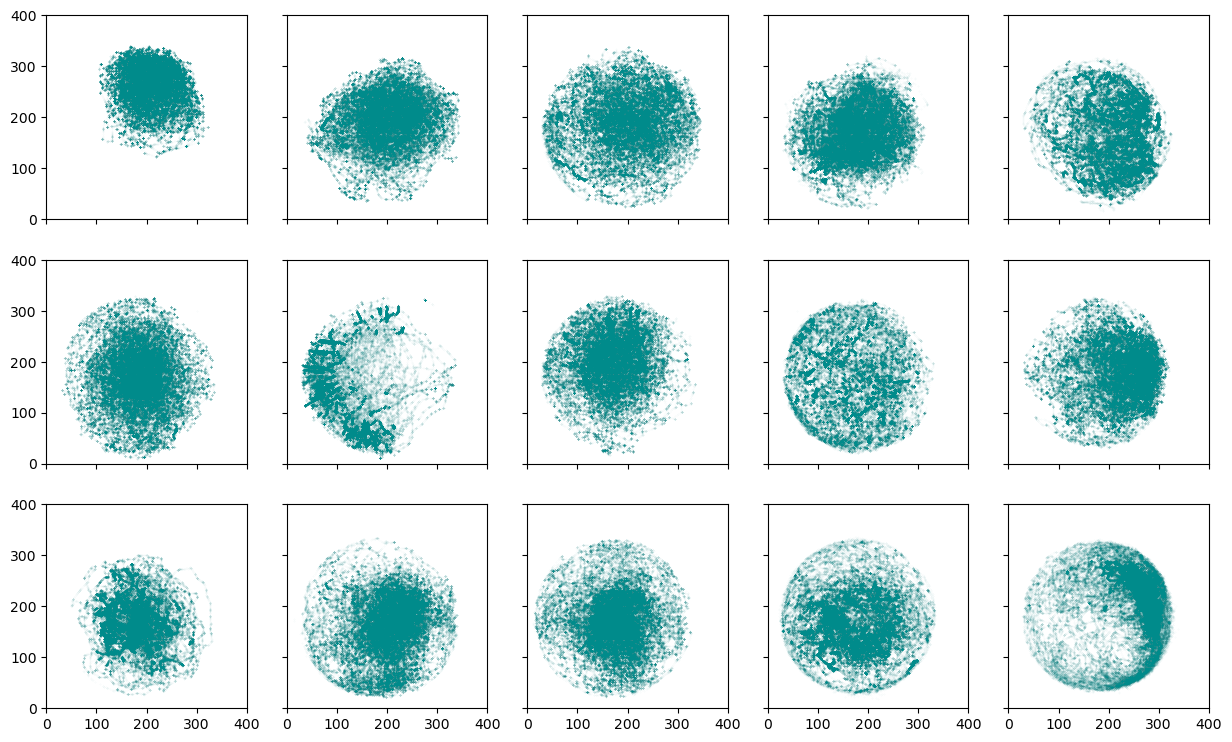

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,9), sharex=True, sharey=True)
axes = axes.ravel()

for f in range(n_fish):
    ax = axes[f]
    filtered_df = fish_df_long[(fish_df_long['fish_number'] == f)]
    ax.scatter(filtered_df['x'], filtered_df['y'], s=.1, alpha=.04, color='darkcyan')
    ax.set_xlim(0, 400)
    ax.set_ylim(0, 400)

plt.show()

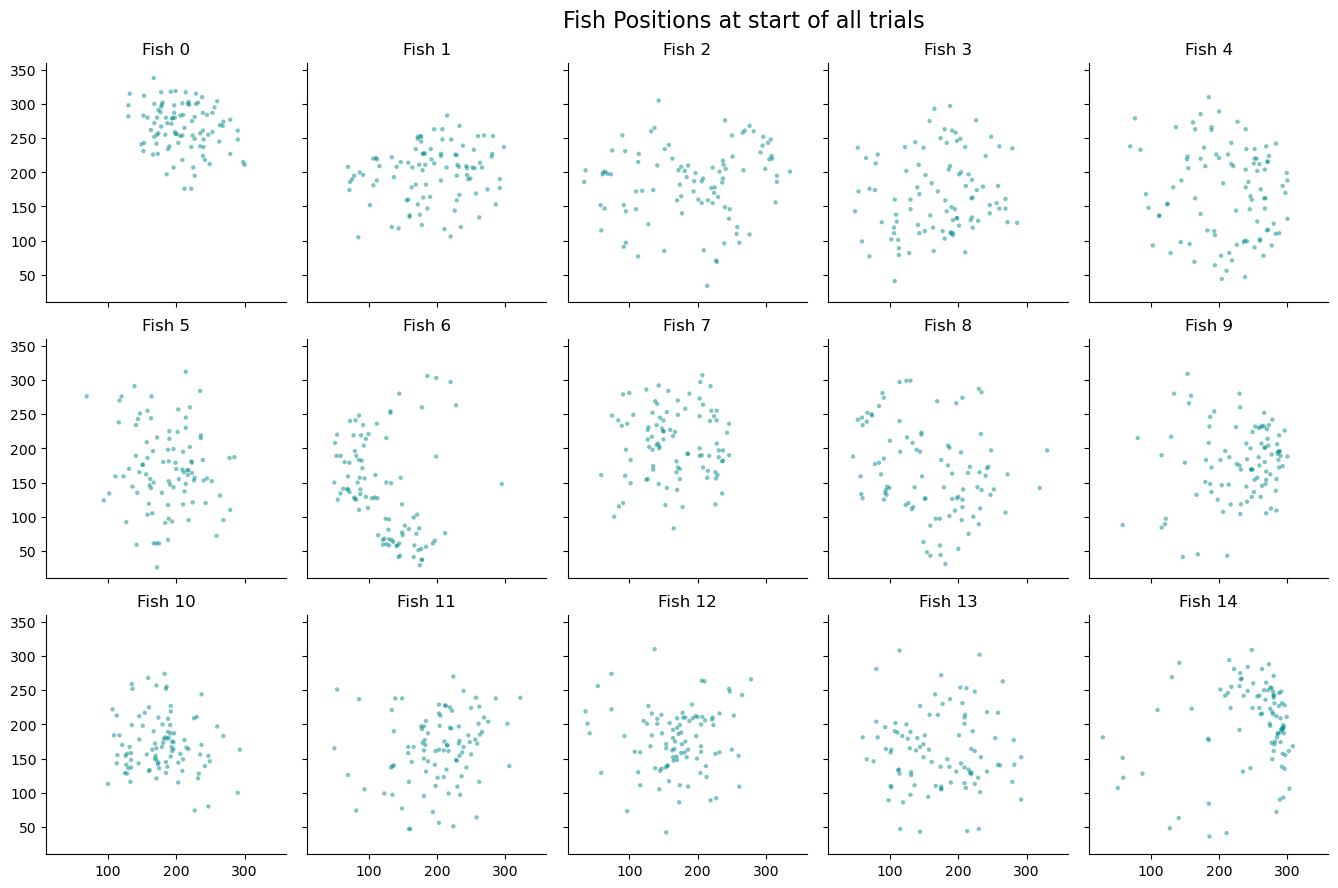

In [30]:
# 1. Subset to trial start & left‐side
df0 = fish_df_long[
    (fish_df_long['frame_count_stimulus'] == 0) &
    (fish_df_long['stimulus'] != 'inter_stim_pause')].copy()

# 2. Compute global limits
x_min, x_max = df0['x'].min(), df0['x'].max()
y_min, y_max = df0['y'].min(), df0['y'].max()

# 3. Fish list & subplot grid
fish_ids = sorted(df0['fish_number'].unique())
ncols = 5
nrows = int(np.ceil(len(fish_ids) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 3 * nrows),
                         sharex=True, sharey=True)
axes_flat = axes.flatten()

# 4. Plot scatter for each fish
for ax, fish in zip(axes_flat, fish_ids):
    sub = df0[df0['fish_number'] == fish]
    ax.scatter(sub['x'], sub['y'],
               s=10,          # marker size
               alpha=0.5, # semi‐transparent
               color='darkcyan',
               edgecolor='none')

    ax.set_title(f'Fish {fish}')
    ax.set_aspect('equal')
    ax.set_xlim(10, 360)
    ax.set_ylim(10, 360)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# 5. Turn off unused axes
for ax in axes_flat[len(fish_ids):]:
    ax.axis('off')

fig.suptitle('Fish Positions at start of all trials', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

#### Example plot of fish and stimuli in absolute coordinates


Select trial

In [20]:
TRIAL = 1
FISH = 0
frames_before = 300
seconds_display = 30

# Filter the DataFrame for fish 0, trial 1, and stimulus_block 2
filtered_df = fish_df_long[(fish_df_long['fish_number'] == FISH) &
                           (fish_df_long['trial_id'] == TRIAL) &
                           (fish_df_long['stimulus_block_id'] == (TRIAL*2)) &
                           (fish_df_long['frame_count_stimulus'] <= (seconds_display * framerate))]

# Get the frame numbers for the selected data
selected_frames = filtered_df['frame']

# Filter the DataFrame for the 200 frames before the selected frames
previous_frames_df = fish_df_long[(fish_df_long['fish_number'] == FISH) &
                                   (fish_df_long['frame'] >= (min(selected_frames) - frames_before)) &
                                   (fish_df_long['frame'] < min(selected_frames))]

stim_trial_df = stim_ego_dict[f'f{FISH}'][stim_ego_dict[f'f{FISH}']['frame'].isin(filtered_df['frame'])]

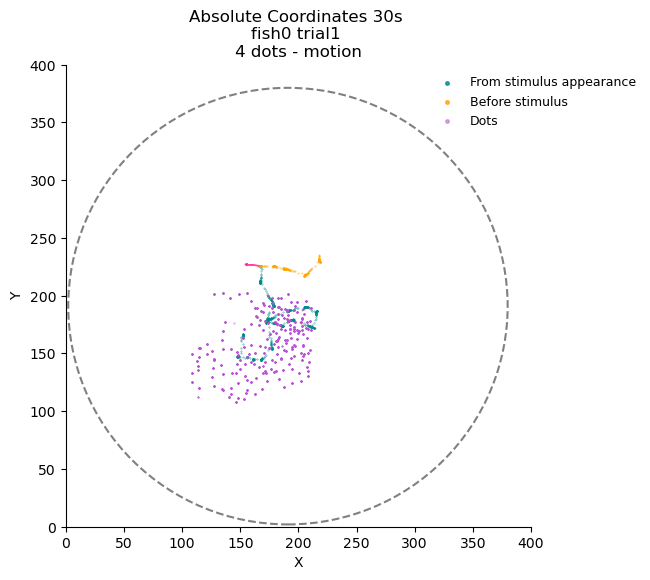

In [223]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the filtered data (frames from the stimulus)
ax.scatter(filtered_df['x'], filtered_df['y'], s=.1, alpha=.8, color='darkcyan', label="From stimulus appearance")

# Plot the previous frames (frames before the stimulus)
ax.scatter(previous_frames_df['x'], previous_frames_df['y'], s=.1, alpha=.8, color='orange', label="Before stimulus")

# Convert orientation to radians and compute direction vector
ori_rad_t0 = filtered_df['ori'].iloc[0]
dx, dy = np.cos(ori_rad_t0), np.sin(ori_rad_t0)
arrow_length = 10  # Adjust length if needed

# Add a small orientation line if needed (same code as your previous plot)
ax.arrow(filtered_df['x'].iloc[0], filtered_df['y'].iloc[0], dx * arrow_length, dy * arrow_length, head_width=2, head_length=2, fc='deeppink', ec='deeppink', alpha=0.8)

for dot in range(n_stimuli):
    if stim_trial_df[f'd{dot}_x_ego'].any():
        if dot == 0:
            ax.scatter(stim_trial_df[f'd{dot}_x'], stim_trial_df[f'd{dot}_y'], s=.1, alpha=.5, color='mediumorchid', label="Dots")
        else:
            ax.scatter(stim_trial_df[f'd{dot}_x'], stim_trial_df[f'd{dot}_y'], s=.1, alpha=.5, color='mediumorchid')


# Add a circle (same as your previous plot)
cx, cy, radius = roi_df.loc[FISH, 'x'] - roi_df.loc[FISH, 'xoff'], roi_df.loc[FISH, 'y'] - roi_df.loc[FISH, 'yoff'], roi_df.loc[FISH, 'radius']
circle = plt.Circle((cx, cy), radius, color='grey', fill=False, linewidth=1.5, linestyle='--')
ax.add_patch(circle)

# Formatting
ax.invert_yaxis()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0, 400)
ax.set_ylim(0, 400)

ndots = filtered_df["stimulus"].iloc[0].split('d')[1][0]
condition = filtered_df["condition_grouped"].iloc[0].split('_')[1]

# Add a title
ax.set_title(f'Absolute Coordinates {seconds_display}s \n'
             f'fish{FISH} trial{TRIAL} \n'
             f'{ndots} dots - {condition}')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1), fontsize=9, frameon=False, markerscale=8)

ax.grid(False)
# plt.savefig(path_figures / rf"f{FISH}_t{TRIAL}_abs_{seconds_display//framerate}s.pdf", dpi=600, bbox_inches='tight')
# plt.savefig(path_figures / rf"f{FISH}_t{TRIAL}_abs_{seconds_display//framerate}s.png", dpi=600, bbox_inches='tight')

plt.show()

Plot fish position egocentric

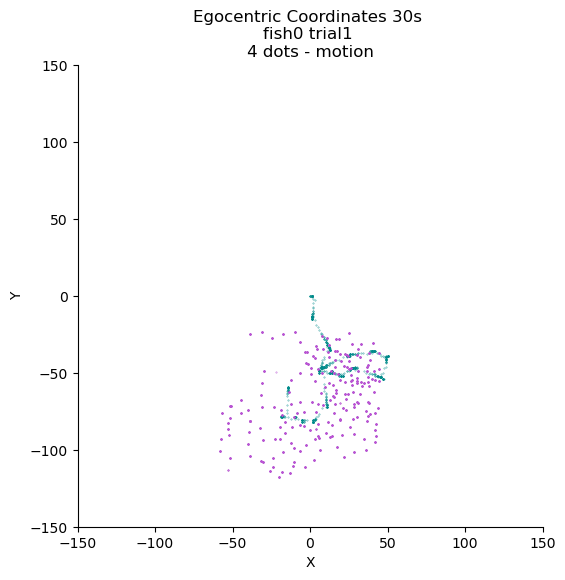

In [20]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the filtered data (frames from the stimulus)
ax.scatter(filtered_df['x_ego'], filtered_df['y_ego'], s=.1, alpha=.8, color='darkcyan')

for dot in range(n_stimuli):
    if stim_trial_df[f'd{dot}_x_ego'].any():
        ax.scatter(stim_trial_df[f'd{dot}_x_ego'], stim_trial_df[f'd{dot}_y_ego'], s=.1, alpha=.5, color='mediumorchid')

# Formatting
ax.invert_yaxis()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-150, 150)
ax.set_ylim(-150, 150)

ndots = filtered_df["stimulus"].iloc[0].split('d')[1][0]
condition = filtered_df["condition_grouped"].iloc[0].split('_')[1]

# Add a title
ax.set_title(f'Egocentric Coordinates {seconds_display}s \n'
             f'fish{FISH} trial{TRIAL} \n'
             f'{ndots} dots - {condition}')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(False)
plt.savefig(path_figures / rf"f{FISH}_t{TRIAL}_ego_{seconds_display}s.pdf", dpi=600, bbox_inches='tight')
plt.savefig(path_figures / rf"f{FISH}_t{TRIAL}_ego_{seconds_display}s.png", dpi=600, bbox_inches='tight')
plt.show()

Plot fish position rotated

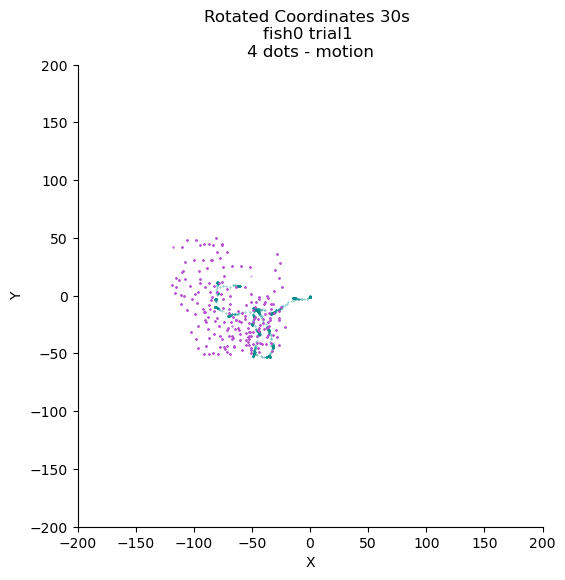

In [21]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the filtered data (frames from the stimulus)
ax.scatter(filtered_df['x_rot'], filtered_df['y_rot'], s=.1, alpha=.8, color='darkcyan')

for dot in range(n_stimuli):
    if stim_trial_df[f'd{dot}_x_ego'].any():
        ax.scatter(stim_trial_df[f'd{dot}_x_rot'], stim_trial_df[f'd{dot}_y_rot'], s=.1, alpha=.5, color='mediumorchid')

# Formatting
ax.invert_yaxis()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)

ndots = filtered_df["stimulus"].iloc[0].split('d')[1][0]
condition = filtered_df["condition_grouped"].iloc[0].split('_')[1]

# Add a title
ax.set_title(f'Rotated Coordinates {seconds_display}s \n'
             f'fish{FISH} trial{TRIAL} \n'
             f'{ndots} dots - {condition}')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(False)
plt.savefig(path_figures / rf"f{FISH}_t{TRIAL}_rot_{seconds_display}s.pdf", dpi=600, bbox_inches='tight', transparent=True)
plt.savefig(path_figures / rf"f{FISH}_t{TRIAL}_rot_{seconds_display}s.png", dpi=600, bbox_inches='tight', transparent=True)
plt.show()

Plot grids of fish and fish position absolute coordinates to visually inspect when stimuli are out of the ROI

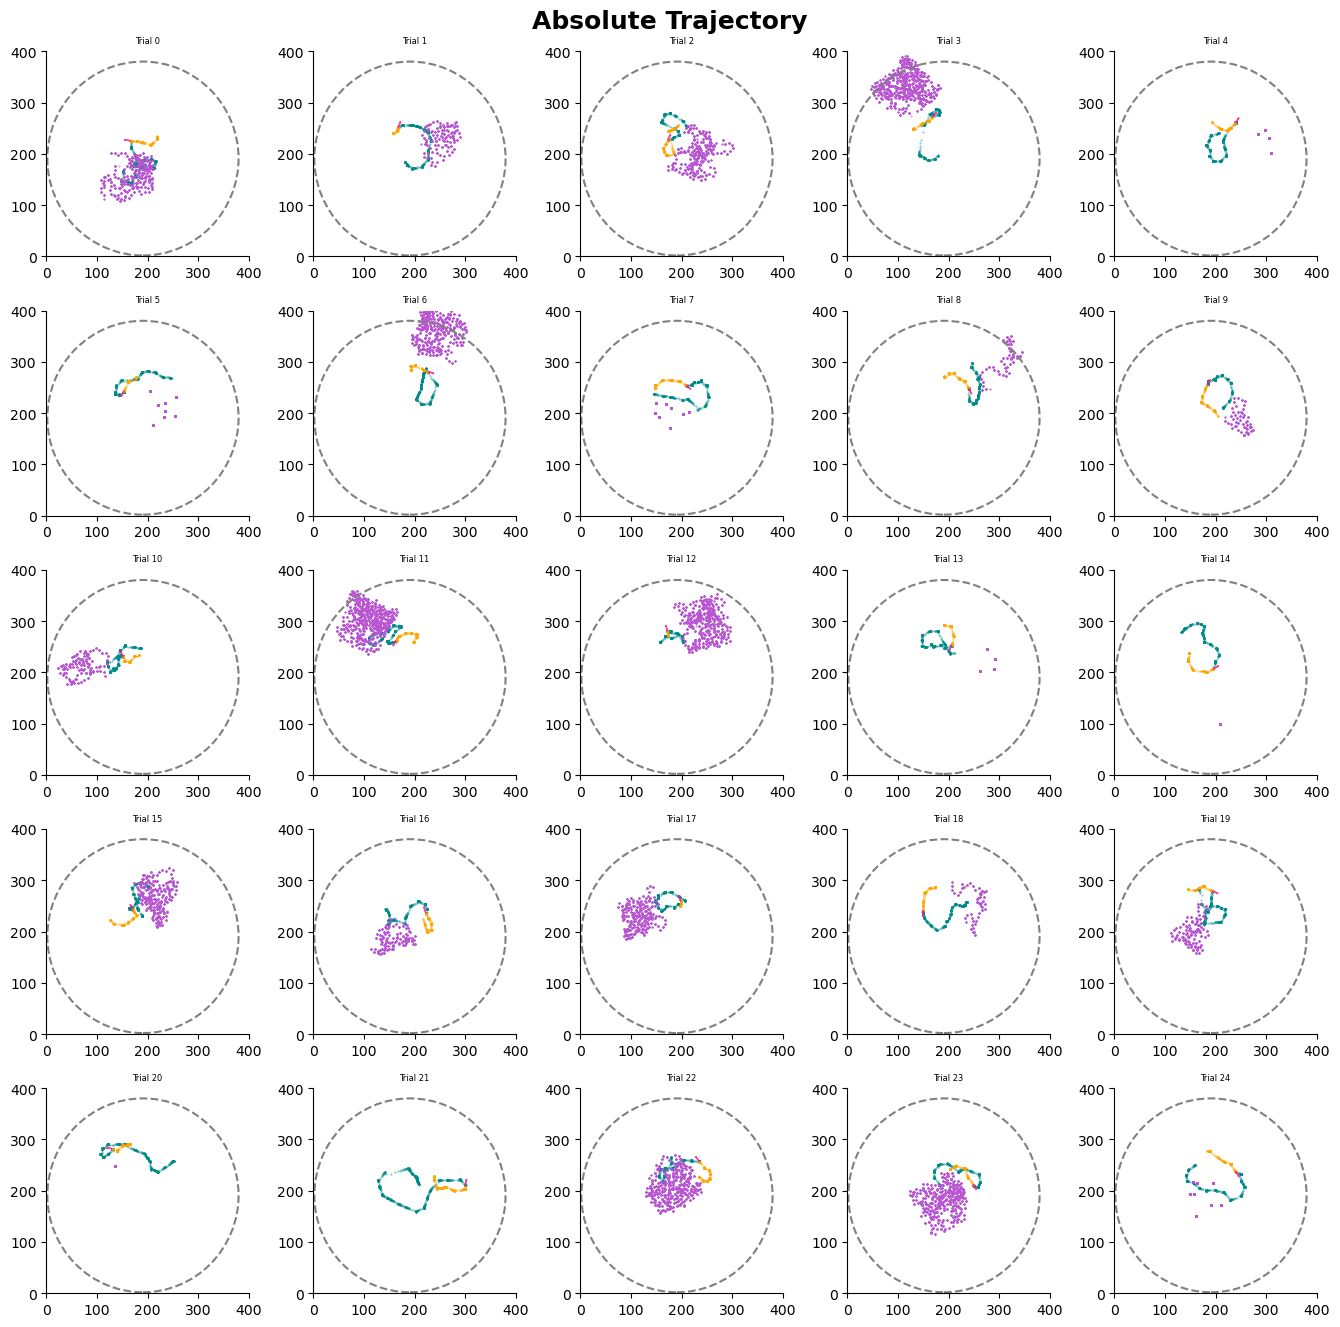

In [128]:
n_rows, n_cols = 5, 5

for fish in range(n_fish):
    # Create a figure with 5 rows and 5 columns
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_rows*2.7, n_cols*2.7))  # Adjust the figsize as needed
    axs = axs.flatten()  # Flatten the 2D array of axes to make indexing easier

    # Loop through each trial (assuming you have 25 trials, indexed from 0 to 24)
    for i, ax in enumerate(axs):
        trial = i + 1  # Trial number starts from 1, you can adjust this if needed
        filtered_df = fish_df_long[(fish_df_long['fish_number'] == fish) &
                                   (fish_df_long['trial_id'] == trial) &
                                   (fish_df_long['stimulus_block_id'] == trial*2) &  # Adjust based on your stimulus block ID logic
                                   (fish_df_long['frame_count_stimulus'] <= (seconds_display * framerate))]

        # Get the frame numbers for the selected data
        selected_frames = filtered_df['frame']

        # Filter the DataFrame for the 200 frames before the selected frames
        previous_frames_df = fish_df_long[(fish_df_long['fish_number'] == fish) &
                                           (fish_df_long['frame'] >= (min(selected_frames) - frames_before)) &
                                           (fish_df_long['frame'] < min(selected_frames))]

        stim_trial_df = stim_ego_dict[f'f{fish}'][stim_ego_dict[f'f{fish}']['frame'].isin(filtered_df['frame'])]

        # Plot the filtered data (frames from the stimulus)
        ax.scatter(filtered_df['x'], filtered_df['y'], s=.1, alpha=.8, color='darkcyan')

        # Plot the previous frames (frames before the stimulus)
        ax.scatter(previous_frames_df['x'], previous_frames_df['y'], s=.1, alpha=.8, color='orange')

        # Convert orientation to radians and compute direction vector
        ori_rad_t0 = filtered_df['ori'].iloc[0]
        dx, dy = np.cos(ori_rad_t0), np.sin(ori_rad_t0)
        arrow_length = 10  # Adjust length if needed

        # Add a small orientation line if needed
        ax.arrow(filtered_df['x'].iloc[0], filtered_df['y'].iloc[0], dx * arrow_length, dy * arrow_length, head_width=2, head_length=2, fc='deeppink', ec='deeppink', alpha=0.8)

        for dot in range(n_stimuli):
            if stim_trial_df[f'd{dot}_x_ego'].any():
                ax.scatter(stim_trial_df[f'd{dot}_x'], stim_trial_df[f'd{dot}_y'], s=.1, alpha=.5, color='mediumorchid')

        # Add a circle (same as your previous plot)
        cx, cy, radius = roi_df.loc[FISH, 'x'] - roi_df.loc[FISH, 'xoff'], roi_df.loc[FISH, 'y'] - roi_df.loc[FISH, 'yoff'], roi_df.loc[FISH, 'radius']
        circle = plt.Circle((cx, cy), radius, color='grey', fill=False, linewidth=1.5, linestyle='--')
        ax.add_patch(circle)

        # Formatting for each subplot
        ax.invert_yaxis()
        ax.set_xlim(0, 400)
        ax.set_ylim(0, 400)

        ax.set_title(f'Trial {trial-1}', fontsize=6)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(False)

    # Adjust layout and save
    # Add general title
    fig.suptitle("Absolute Trajectory", fontsize=18, fontweight="bold")
    plt.tight_layout()

    # Adjust layout to avoid overlap
    plt.tight_layout()

    # plt.savefig(path_figures / rf"f{fish}_t0-{trial}_abs_{seconds_display}s.pdf", dpi=1200, bbox_inches='tight')
    # plt.savefig(path_figures / rf"f{fish}_t0-{trial}_abs_{seconds_display}s.png", dpi=1200, bbox_inches='tight')
    if fish == FISH:
        plt.show()
        plt.close()
    else:
        plt.close()
    # Show the plot


Plot grids of fish position egocentric

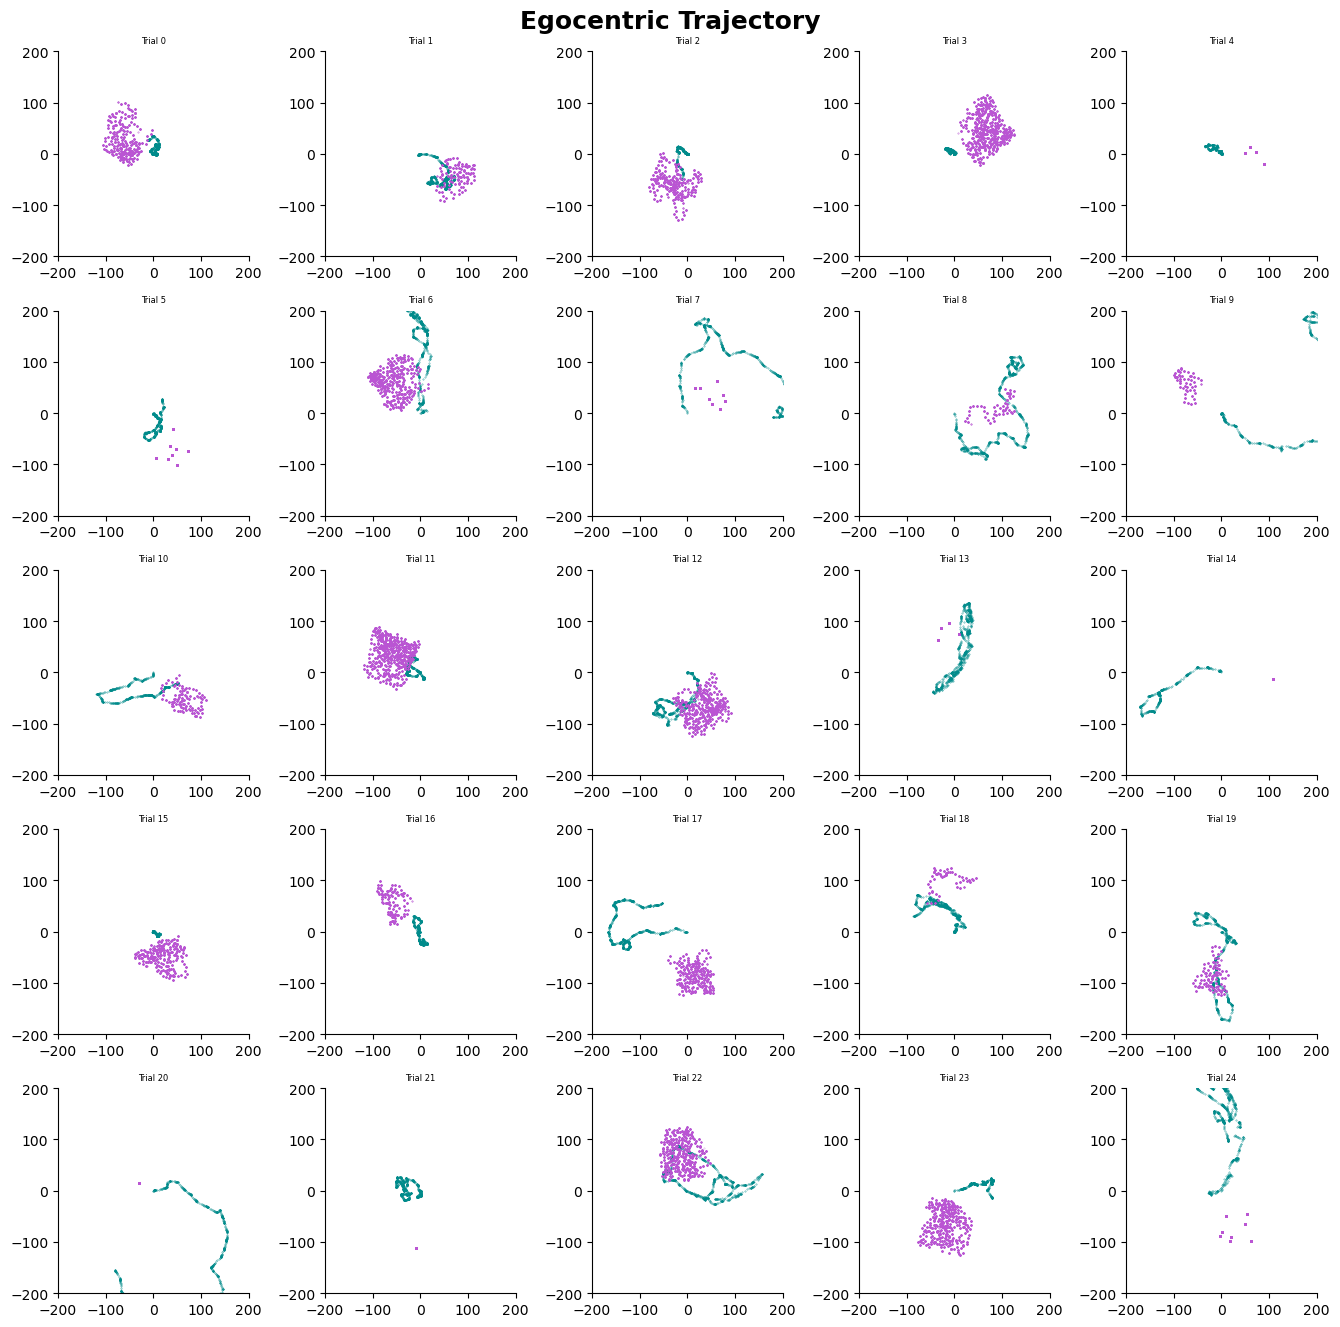

In [21]:
n_rows, n_cols = 5, 5

for fish in range(n_fish):
    # Create a figure with 5 rows and 5 columns
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_rows*2.7, n_cols*2.7))  # Adjust the figsize as needed
    axs = axs.flatten()  # Flatten the 2D array of axes to make indexing easier

    # Loop through each trial (assuming you have 25 trials, indexed from 0 to 24)
    for i, ax in enumerate(axs):
        trial = i + 1  # Trial number starts from 1, you can adjust this if needed
        filtered_df = fish_df_long[(fish_df_long['fish_number'] == fish) &
                                   (fish_df_long['trial_id'] == trial) &
                                   (fish_df_long['stimulus_block_id'] == trial*2) &  # Adjust based on your stimulus block ID logic
                                   (fish_df_long['frame_count_stimulus'] <= (seconds_display * framerate))]

        stim_trial_df = stim_ego_dict[f'f{fish}'][stim_ego_dict[f'f{fish}']['frame'].isin(filtered_df['frame'])]

        # Plot the filtered data (frames from the stimulus)
        ax.scatter(filtered_df['x_ego'], filtered_df['y_ego'], s=.1, alpha=.8, color='darkcyan')

        for dot in range(n_stimuli):
            if stim_trial_df[f'd{dot}_x_ego'].any():
                ax.scatter(stim_trial_df[f'd{dot}_x_ego'], stim_trial_df[f'd{dot}_y_ego'], s=.1, alpha=.5, color='mediumorchid')

        # Formatting for each subplot
        ax.invert_yaxis()
        ax.set_xlim(-250, 250)
        ax.set_ylim(-250, 250)

        ax.set_title(f'Trial {trial-1}', fontsize=6)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(False)

    # Adjust layout and save
    # Add general title
    fig.suptitle("Egocentric Trajectory", fontsize=18, fontweight="bold")
    plt.tight_layout()

    # Adjust layout to avoid overlap
    plt.tight_layout()
    # plt.savefig(path_figures / rf"f{fish}_t0-{trial}_ego_{seconds_display}s.pdf", dpi=1200, bbox_inches='tight')
    # plt.savefig(path_figures / rf"f{fish}_t0-{trial}_ego_{seconds_display}s.png", dpi=1200, bbox_inches='tight')

    if fish == FISH:
        plt.show()
        plt.close()
    else:
        plt.close()


In [ ]:
n_rows, n_cols = 5, 5

for fish in range(n_fish):
    # Create a figure with 5 rows and 5 columns
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_rows*2.7, n_cols*2.7))  # Adjust the figsize as needed
    axs = axs.flatten()  # Flatten the 2D array of axes to make indexing easier

    # Loop through each trial (assuming you have 25 trials, indexed from 0 to 24)
    for i, ax in enumerate(axs):
        trial = i + 1  # Trial number starts from 1, you can adjust this if needed
        filtered_df = fish_df_long[(fish_df_long['fish_number'] == fish) &
                                   (fish_df_long['trial_id'] == trial) &
                                   (fish_df_long['stimulus_block_id'] == trial*2) &  # Adjust based on your stimulus block ID logic
                                   (fish_df_long['frame_count_stimulus'] <= (seconds_display * framerate))]

        stim_trial_df = stim_ego_dict[f'f{fish}'][stim_ego_dict[f'f{fish}']['frame'].isin(filtered_df['frame'])]

        # Plot the filtered data (frames from the stimulus)
        ax.scatter(filtered_df['x_rot'], filtered_df['y_rot'], s=.1, alpha=.8, color='darkcyan')

        for dot in range(n_stimuli):
            if stim_trial_df[f'd{dot}_x_ego'].any():
                ax.scatter(stim_trial_df[f'd{dot}_x_rot'], stim_trial_df[f'd{dot}_y_rot'], s=.1, alpha=.5, color='mediumorchid')

        # Formatting for each subplot
        ax.axhline(0, color='grey', linewidth=0.5, linestyle='--')
        ax.axvline(0, color='grey', linewidth=0.5, linestyle='--')
        ax.set_xlim(-250, 250)
        ax.set_ylim(-250, 250)
        ax.set_title(f'Trial {trial-1}', fontsize=6)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(False)

    # Adjust layout and save
    # Add general title
    fig.suptitle("Rotated Trajectory", fontsize=18, fontweight="bold")
    plt.tight_layout()

    #plt.savefig(path_figures / rf"f{fish}_t0-{trial}_rot_{seconds_display}s.pdf", dpi=1200, bbox_inches='tight')
    #plt.savefig(path_figures / rf"f{fish}_t0-{trial}_rot_{seconds_display}s.png", dpi=1200, bbox_inches='tight')

    if fish == FISH:
        plt.show()
        plt.close()
    else:
        plt.close()


### Plots

#### Plot fish position over time after fish appearance (group by side and condition)

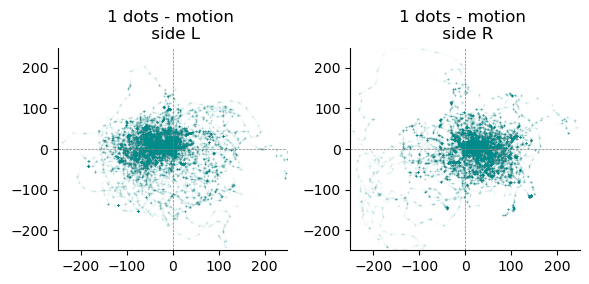

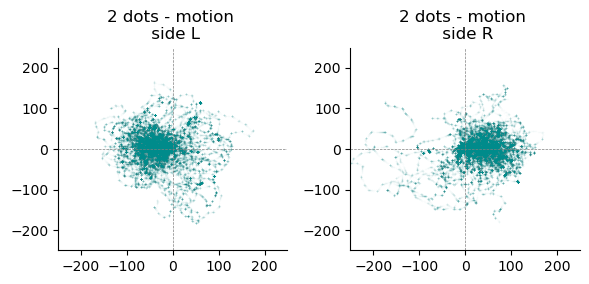

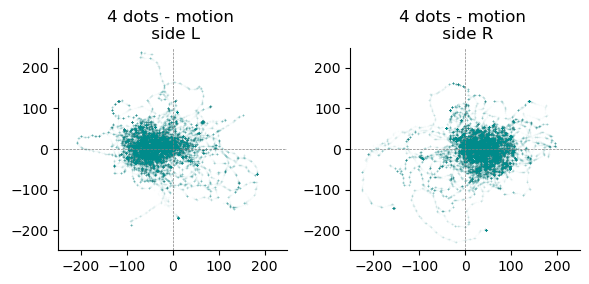

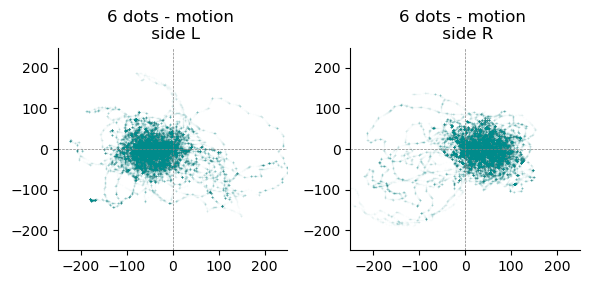

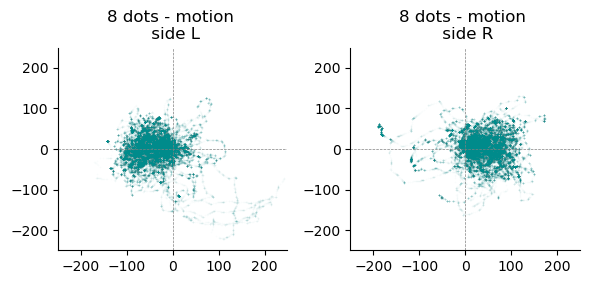

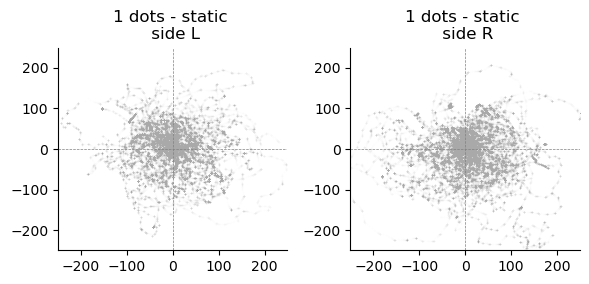

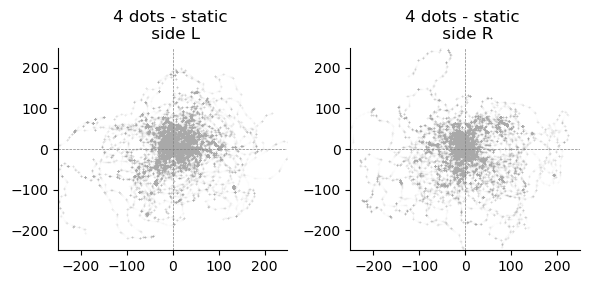

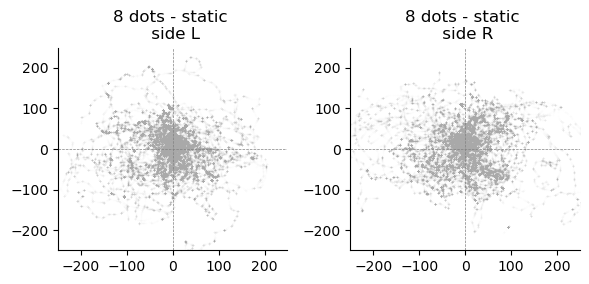

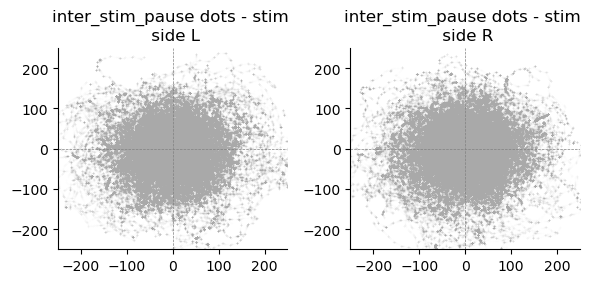

In [22]:
# Get unique conditions and stimulus sides
stimuli = ["d1s3.5", "d2s3.5", "d4s3.5", "d6s3.5", "d8s3.5", "d1s0", "d4s0", "d8s0", "inter_stim_pause"]
stim_sides = ['L', 'R']

# Create subplots: 1 row per condition, 2 columns for 'L' and 'R' stimulus sides
#fig, axs = plt.subplots(nrows=len(stimuli), ncols=2, figsize=(8, 4 * len(stimuli)))
#axs = axs.flatten()

# Loop over each condition and stimulus side (L and R)
for i, stim in enumerate(stimuli):
    seconds_to_display = 50
    # Filter data for the current condition
    stim_data = fish_df_long[(fish_df_long['stimulus'] == stim) &
                             (fish_df_long['frame_count_stimulus'] < seconds_to_display*framerate)].copy()

    fig, axs = plt.subplots(ncols=2, figsize=(6, 3))
    # Loop through stimulus sides (L and R)
    for j, stim_side in enumerate(stim_sides):
        # Filter the data for the current stim_side
        stim_side_data = stim_data[stim_data['stim_side'] == stim_side]

        # Select the axis for the current plot (row i, column j)
        #ax = axs[i * 2 + j]
        ax = axs[j]

        # Set title
        ndots = stim.split('d')[1][0] if stim != 'inter_stim_pause' else stim.split('d')[0]
        condition = stim_side_data["condition_grouped"].iloc[0].split('_')[1]

        color = 'darkcyan' if condition == 'motion' else 'darkgrey'
        # Plot the scatterplot of x_rot vs. y_rot
        ax.scatter(stim_side_data['x_rot'], stim_side_data['y_rot'], s=.2, alpha=0.020, c=color)

        ax.set_title(f'{ndots} dots - {condition} \n'
                     f' side {stim_side}')

        ax.axhline(0, color='grey', linewidth=0.5, linestyle='--')
        ax.axvline(0, color='grey', linewidth=0.5, linestyle='--')

        ax.set_xlim(-250, 250)
        ax.set_ylim(-250, 250)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(False)

        # Adjust layout to make it look neat
        plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust rect to make space for the title

        #plt.savefig(path_figures / rf"trot_{stim}.pdf", dpi=1200, bbox_inches='tight')
        #plt.savefig(path_figures / rf"trot_{stim}.png", dpi=1200, bbox_inches='tight')

    plt.show()

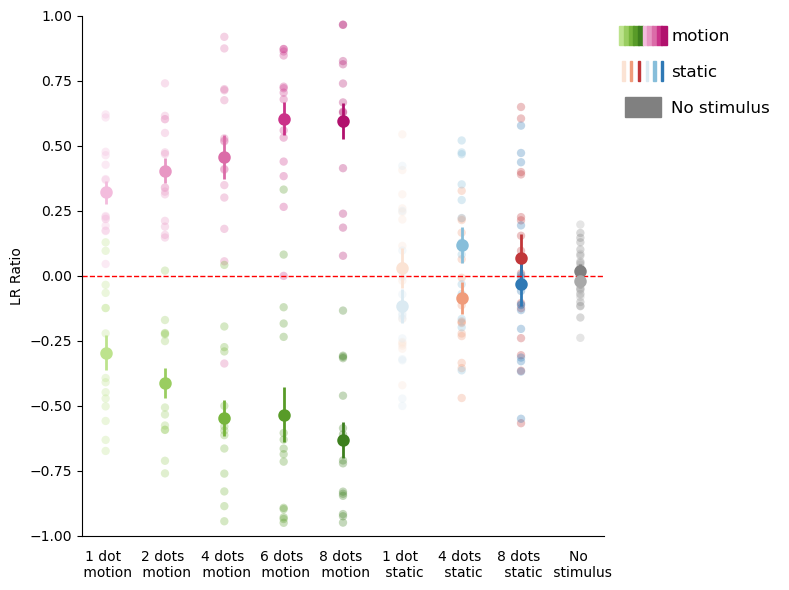

In [30]:
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerTuple

stim_labels = {}
for stim in stimuli:
    if stim == 'inter_stim_pause':
        stim_labels[stim] = 'No \n stimulus'
    else:
        dot_num = stim.split('s')[0].replace('d', '')  # e.g., 'd1' → '1'
        speed = stim.split('s')[1]
        motion_label = 'motion' if speed != '0' else 'static'
        stim_labels[stim] = f"{dot_num} dot{'s' if dot_num != '1' else ''} \n {motion_label}"

stimuli_35 = ["d1s3.5", "d2s3.5", "d4s3.5", "d6s3.5", "d8s3.5"]
stimuli_0 = ["d1s0", "d4s0", "d8s0"]
stimuli = stimuli_35 + stimuli_0 + ['inter_stim_pause']
stim_sides = ['L', 'R']  # Both sides

lr_ratios_per_stim_side = {}

for stim in stimuli:
    for side in stim_sides:
        stim_data = fish_df_long[(fish_df_long['stimulus'] == stim) &
                                 (fish_df_long['stim_side'] == side)].copy()

        # Masks
        left_mask = stim_data['x_rot'] < 0
        right_mask = stim_data['x_rot'] > 0

        # Time per trial per fish
        left_time = stim_data[left_mask].groupby(['fish_number', 'trial_id']).size() / framerate
        right_time = stim_data[right_mask].groupby(['fish_number', 'trial_id']).size() / framerate

        # Average per fish
        left_avg = left_time.groupby('fish_number').mean()
        right_avg = right_time.groupby('fish_number').mean()

        # LR ratio
        lr_ratio = (left_avg - right_avg) / (left_avg + right_avg)
        lr_ratios_per_stim_side[(stim, side)] = lr_ratio

# Color palettes
pink_purple_palette = sns.color_palette("PiYG", n_colors=len(stimuli_35)*2+5) #[:len(stimuli_35)] [-len(stimuli_35):]
red_blue_palette = sns.color_palette("RdBu", n_colors=len(stimuli_0)*2) #[:len(stimuli_0)]  # lighter to darker grays

#-(stimuli_35.index(stim)+1) , (stimuli_35.index(stim)+1)

fig, ax = plt.subplots(figsize=(8, 6))

x = np.arange(len(stimuli))
width = 0.35  # For offsetting L and R

for i, stim in enumerate(stimuli):
    for j, side in enumerate(stim_sides):
        y = lr_ratios_per_stim_side.get((stim, side), pd.Series(dtype=float))

        # Assign color based on condition and side
        if stim in stimuli_35:  # s3.5
            base_color = pink_purple_palette[:len(stimuli_35)][-(stimuli_35.index(stim)+1)] if side == 'L' \
                else pink_purple_palette[-len(stimuli_35):][stimuli_35.index(stim)]
        elif stim in stimuli_0:
            base_color = red_blue_palette[:len(stimuli_0)][-(stimuli_0.index(stim)+1)] if side == 'L' \
                else red_blue_palette[-len(stimuli_0):][stimuli_0.index(stim)]
        else:
            base_color = 'gray' if side == 'L' else 'darkgray'

        color = base_color if side == 'L' else base_color  # you can modify for different shades if desired

        xpos = x[i] #+ (width/2 if side == 'R' else -width/2)
        ax.scatter([xpos]*len(y), y, color=base_color, edgecolor='none', alpha=.3)
        ax.errorbar(xpos, y.mean(), yerr=y.sem(), fmt='o', color=color,
                    capsize=0, elinewidth=2, markeredgecolor=color, markeredgewidth=3)

import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerTuple

# --- Rebuild exact colors used for the legend ---
motion_colors_L = [pink_purple_palette[:len(stimuli_35)][-(stimuli_35.index(st)+1)] for st in stimuli_35]
motion_colors_R = [pink_purple_palette[-len(stimuli_35):][stimuli_35.index(st)] for st in stimuli_35]
motion_colors = motion_colors_R + motion_colors_L

static_colors_L = [red_blue_palette[:len(stimuli_0)][-(stimuli_0.index(st)+1)] for st in stimuli_0]
static_colors_R = [red_blue_palette[-len(stimuli_0):][stimuli_0.index(st)] for st in stimuli_0]
static_colors = static_colors_L + static_colors_R

motion_patches = tuple(mpatches.Patch(color=c) for c in motion_colors)
static_patches = tuple(mpatches.Patch(color=c) for c in static_colors)
pause_patch = mpatches.Patch(color="gray")

handles = [motion_patches, static_patches, pause_patch]
labels = ["motion", "static", "No stimulus"]

# Give the right side some room for the legend
plt.subplots_adjust(right=0.78)  # widen margin; tweak to taste (0.75–0.82)

# Add a bigger, right-side legend outside the axes
leg = ax.legend(handles, labels,
                handler_map={tuple: HandlerTuple(ndivide=None)},  # show all squares inline per label
                loc="upper left", bbox_to_anchor=(1.02, 1.0),     # outside on the right
                frameon=False, title=None,
                borderaxespad=0.0, borderpad=0.6,
                handleheight=1.4, handlelength=2.2,               # bigger squares for Patch
                labelspacing=1.0, handletextpad=0.6,
                prop={"size": 12}, title_fontsize=12)
# Aesthetics
ax.axhline(0, linestyle='--', color='red', linewidth=1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(x)
ax.set_xticklabels([stim_labels[stim] for stim in stimuli], ha='center')

ax.tick_params(axis='x', length=0)
ax.xaxis.set_tick_params(pad=10)  # You can increase 10 to move them further down

ax.set_ylabel("LR Ratio")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(-1, 1)
plt.tight_layout()
plt.savefig(path_figures / rf"LRratio.pdf", dpi=1200, bbox_inches='tight')
plt.savefig(path_figures / rf"LRratio.png", dpi=1200, bbox_inches='tight')
plt.show()


In [26]:
pink_purple_palette

[(0.6921953094963476, 0.06789696270665128, 0.42737408688965783),
 (0.7975394079200308, 0.19784698193002692, 0.5391772395232602),
 (0.8590542099192618, 0.42422145328719724, 0.6597462514417531),
 (0.9085736255286428, 0.5926182237600922, 0.770319108035371),
 (0.9515570934256055, 0.7363321799307958, 0.8662053056516723),
 (0.9810841983852364, 0.839677047289504, 0.9178777393310265),
 (0.9829296424452134, 0.9138023836985775, 0.9495578623606306),
 (0.9673202614379085, 0.968473663975394, 0.9656286043829296),
 (0.9254901960784314, 0.9635524798154557, 0.8696655132641293),
 (0.8524413687043447, 0.9392541330257594, 0.7360246059208),
 (0.7392541330257595, 0.8900422914263746, 0.5539407920030761),
 (0.6032295271049597, 0.8055363321799309, 0.3822376009227222),
 (0.46728181468665897, 0.7114186851211073, 0.23521722414455978),
 (0.34425221068819684, 0.608073817762399, 0.15647827758554403),
 (0.2405997693194925, 0.4982698961937716, 0.11649365628604384)]

#### Plots distance

In [56]:
tab20_colors = sns.color_palette("tab20", 10)  # Extract 10 distinct colors

color_map = {
    'd1s3.5': tab20_colors[0],  # Base color for d1s3.5
    'd1s0': tab20_colors[1],  # Lighter version for d1s0

    'd2s3.5': tab20_colors[2],

    'd4s3.5': tab20_colors[4],
    'd4s0': tab20_colors[5],

    'd6s3.5': tab20_colors[6],

    'd8s3.5': tab20_colors[8],
    'd8s0': tab20_colors[9],

    'inter_stim_pause': "gray"  # Neutral color
}

stim_label_map = {
    "d1s3.5": "1 dot - motion",
    "d2s3.5": "2 dots - motion",
    "d4s3.5": "4 dots - motion",
    "d6s3.5": "6 dots - motion",
    "d8s3.5": "8 dots - motion",
    "d1s0": "1 dot - static",
    "d4s0": "4 dots - static",
    "d8s0": "8 dots - static",
}


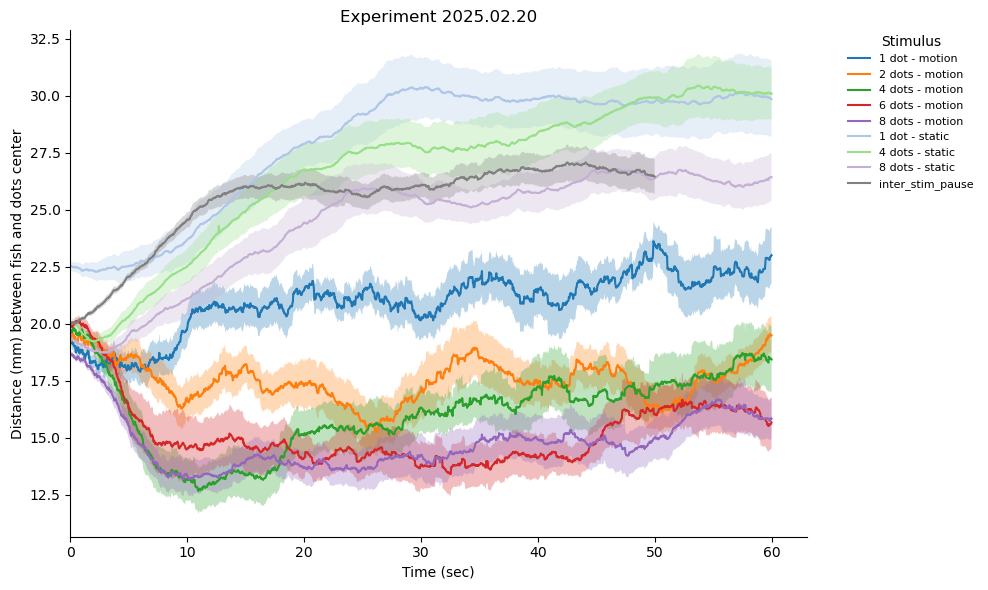

In [147]:
# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

stimuli_order = ["d1s3.5", "d2s3.5", "d4s3.5", "d6s3.5", "d8s3.5", "d1s0", "d4s0", "d8s0", "inter_stim_pause"]

# Loop over each condition in the specified order
for stim in stimuli_order:
    # Filter data for the current stim across all fish
    stim_data = fish_df_long[(fish_df_long['stimulus'] == stim) &
                            (fish_df_long['dots_out'] < 1)].copy()

    stim_data.loc[:, 'dist_mm'] = stim_data['dotsDist_rot'] / PX_TO_MM
    stim_data.loc[:, 'time'] = stim_data['frame_count_stimulus'] / framerate

    # Step 1: Get average distance per fish per time (across trials)
    fish_time_avg = stim_data.groupby(['fish_number', 'time'])['dist_mm'].mean().reset_index()

    # Group by time and calculate the average and standard error of dotDist for each time point
    grouped = fish_time_avg.groupby('time')['dist_mm']
    avg_dotDist_per_time = grouped.mean()
    sem_dotDist_per_time = grouped.sem()  # Standard Error of the Mean

    #ci = avg_dotDist_per_time + 1.96 * sem_dotDist_per_time

    # Get color and alpha for the current stim
    color = color_map[stim]

    # Plot the mean line
    ax.plot(avg_dotDist_per_time.index, avg_dotDist_per_time, label=stim_label_map.get(stim, stim), color=color)

    # Plot the shaded area for SEM
    ax.fill_between(avg_dotDist_per_time.index,
                    avg_dotDist_per_time - sem_dotDist_per_time,
                    avg_dotDist_per_time + sem_dotDist_per_time,
                    alpha=0.3, color=color, edgecolor='none')  # Adjust alpha for transparency

# Set the title and labels
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Distance (mm) between fish and dots center')

# Move the legend outside of the plot on the right
ax.legend(title="Stimulus", loc="upper left", fontsize=8, bbox_to_anchor=(1.05, 1), borderaxespad=0., frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(left=0)
ax.set_title(f"Experiment {date.name}")

# Adjust layout to make it look neat
plt.tight_layout()
# plt.savefig(path_figures / rf"distmm_allcond.pdf", dpi=1200, bbox_inches='tight')
# plt.savefig(path_figures / rf"distmm_allcond.png", dpi=1200, bbox_inches='tight')
# Show the plot
plt.show()

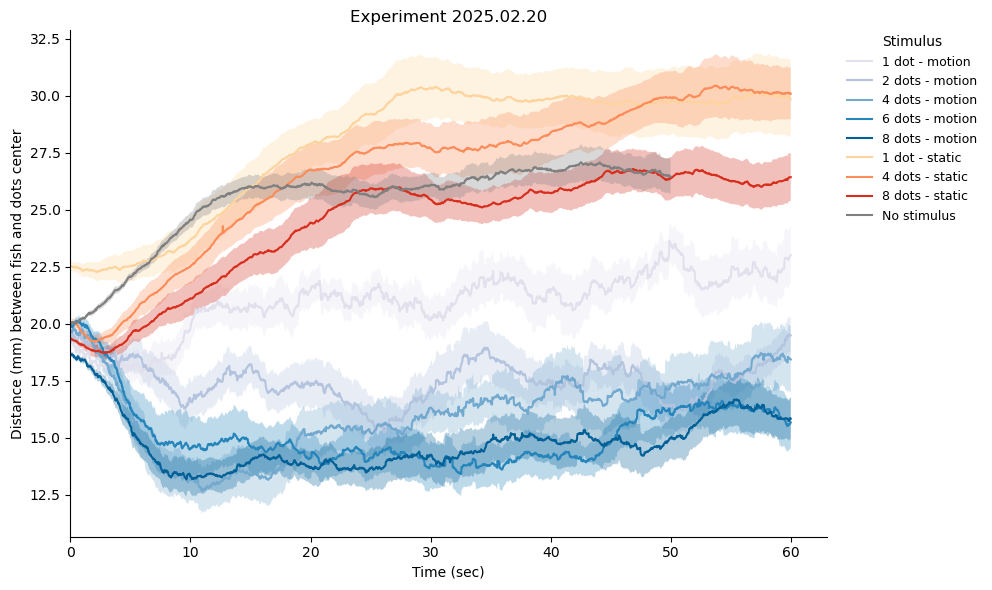

In [31]:
# --- Gradient palettes for motion (s=3.5) and static (s=0), assigned by dot count ---

import re
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------------------
# 1) Helpers to parse and order stimuli
# --------------------------------------
def parse_stim(stim):
    """
    Parse strings like 'd1s3.5' -> (1, 3.5). Returns (None, None) for non-matching (e.g., inter_stim_pause)
    """
    m = re.match(r"d(\d+)s([\d\.]+)$", stim)
    if not m:
        return None, None
    dots = int(m.group(1))
    speed = float(m.group(2))
    return dots, speed

def is_motion(stim):
    dots, speed = parse_stim(stim)
    return dots is not None and speed is not None and speed != 0.0

def is_static(stim):
    dots, speed = parse_stim(stim)
    return dots is not None and speed is not None and speed == 0.0

# Use the order you provided; feel free to change it
stimuli_order = ["d1s3.5", "d2s3.5", "d4s3.5", "d6s3.5", "d8s3.5", "d1s0", "d4s0", "d8s0", "inter_stim_pause"]

# --------------------------------------
# 2) Build gradients
# --------------------------------------
# Choose your colormaps (add _r to reverse light/dark)
MOTION_CMAP = "PuBu"    # e.g., "PuBu", "Blues", "Purples", "viridis"
STATIC_CMAP = "OrRd"    # e.g., "OrRd", "YlOrRd", "Reds", "magma"

# Collect dot counts present for each group
motion_stims = [s for s in stimuli_order if is_motion(s)]
static_stims = [s for s in stimuli_order if is_static(s)]

motion_dots_sorted = sorted({parse_stim(s)[0] for s in motion_stims})
static_dots_sorted = sorted({parse_stim(s)[0] for s in static_stims})

# Generate palettes with as many steps as unique dot counts per group
motion_palette = sns.color_palette(MOTION_CMAP, n_colors=len(motion_dots_sorted))
static_palette = sns.color_palette(STATIC_CMAP, n_colors=len(static_dots_sorted))

# Map each stimulus to the corresponding gradient color by rank of its dot count
def build_color_map():
    cmap = {}

    # Motion colors
    dot_to_motion_color = {
        d: motion_palette[i] for i, d in enumerate(motion_dots_sorted)
    }
    for s in motion_stims:
        d, _ = parse_stim(s)
        cmap[s] = dot_to_motion_color[d]

    # Static colors
    dot_to_static_color = {
        d: static_palette[i] for i, d in enumerate(static_dots_sorted)
    }
    for s in static_stims:
        d, _ = parse_stim(s)
        cmap[s] = dot_to_static_color[d]

    # Pause / other
    cmap["inter_stim_pause"] = "gray"
    return cmap

color_map = build_color_map()

# --------------------------------------
# 3) Optional: auto label map
# --------------------------------------
def stim_label(stim):
    d, speed = parse_stim(stim)
    if stim == "inter_stim_pause":
        return "No stimulus"
    if d is None:
        return stim
    if speed == 0.0:
        return f"{d} dot{'s' if d != 1 else ''} - static"
    else:
        return f"{d} dot{'s' if d != 1 else ''} - motion"

# --------------------------------------
# 4) Plot (your original logic with gradient colors)
# --------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

for stim in stimuli_order:
    # Filter data for the current stim across all fish
    stim_data = fish_df_long[(fish_df_long['stimulus'] == stim) &
                             (fish_df_long['dots_out'] < 1)].copy()

    stim_data.loc[:, 'dist_mm'] = stim_data['dotsDist_rot'] / PX_TO_MM
    stim_data.loc[:, 'time'] = stim_data['frame_count_stimulus'] / framerate

    # Average distance per fish per time (across trials)
    fish_time_avg = stim_data.groupby(['fish_number', 'time'])['dist_mm'].mean().reset_index()

    # Group by time and calculate mean ± SEM
    grouped = fish_time_avg.groupby('time')['dist_mm']
    avg_dotDist_per_time = grouped.mean()
    sem_dotDist_per_time = grouped.sem()

    # Use gradient color
    color = color_map.get(stim, "gray")

    # Mean line
    ax.plot(avg_dotDist_per_time.index, avg_dotDist_per_time,
            label=stim_label(stim), color=color)

    # Shaded SEM
    ax.fill_between(avg_dotDist_per_time.index,
                    avg_dotDist_per_time - sem_dotDist_per_time,
                    avg_dotDist_per_time + sem_dotDist_per_time,
                    alpha=0.3, color=color, edgecolor='none')

# Axes styling
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Distance (mm) between fish and dots center')
ax.set_xlim(left=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(f"Experiment {date.name}")

# Legend outside on the right
plt.subplots_adjust(right=0.78)  # leave room for legend
ax.legend(title="Stimulus", loc="upper left", fontsize=9,
          bbox_to_anchor=(1.02, 1), borderaxespad=0., frameon=False, title_fontsize=10)

plt.tight_layout()
plt.show()


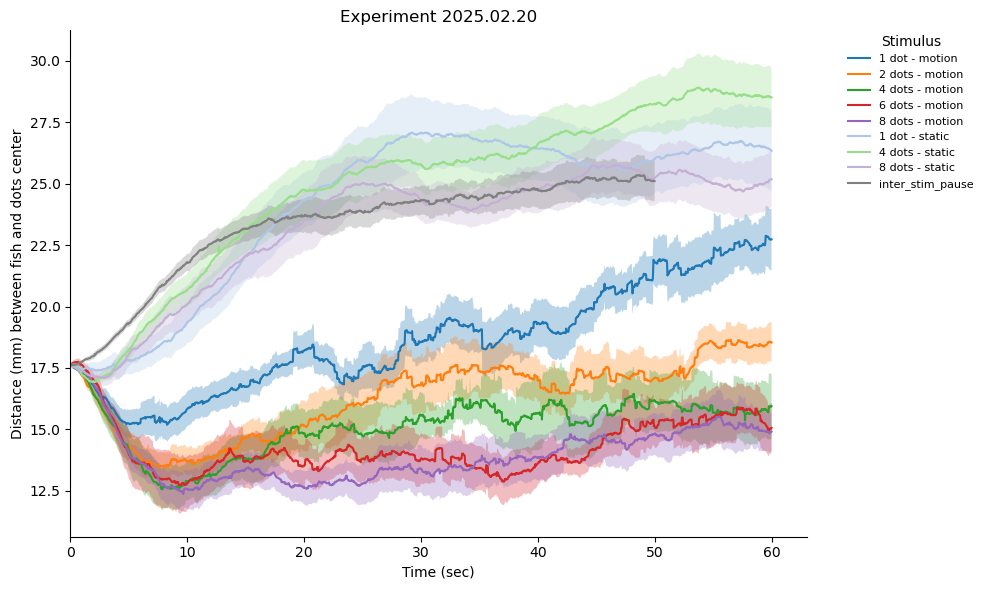

In [57]:
# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

stimuli_order = ["d1s3.5", "d2s3.5", "d4s3.5", "d6s3.5", "d8s3.5", "d1s0", "d4s0", "d8s0", "inter_stim_pause"]

# Loop over each condition in the specified order
for stim in stimuli_order:
    # Filter data for the current stim across all fish
    stim_data = fish_df_long[(fish_df_long['stimulus'] == stim) &
                            (fish_df_long['dots_out'] < 1)].copy()

    stim_data.loc[:, 'dist_mm'] = stim_data['squareDist_rot'] / PX_TO_MM
    stim_data.loc[:, 'time'] = stim_data['frame_count_stimulus'] / framerate

    # Step 1: Get average distance per fish per time (across trials)
    fish_time_avg = stim_data.groupby(['fish_number', 'time'])['dist_mm'].mean().reset_index()

    # Group by time and calculate the average and standard error of dotDist for each time point
    grouped = fish_time_avg.groupby('time')['dist_mm']
    avg_dotDist_per_time = grouped.mean()
    sem_dotDist_per_time = grouped.sem()  # Standard Error of the Mean

    #ci = avg_dotDist_per_time + 1.96 * sem_dotDist_per_time

    # Get color and alpha for the current stim
    color = color_map[stim]

    # Plot the mean line
    ax.plot(avg_dotDist_per_time.index, avg_dotDist_per_time, label=stim_label_map.get(stim, stim), color=color)

    # Plot the shaded area for SEM
    ax.fill_between(avg_dotDist_per_time.index,
                    avg_dotDist_per_time - sem_dotDist_per_time,
                    avg_dotDist_per_time + sem_dotDist_per_time,
                    alpha=0.3, color=color, edgecolor='none')  # Adjust alpha for transparency

# Set the title and labels
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Distance (mm) between fish and dots center')

# Move the legend outside of the plot on the right
ax.legend(title="Stimulus", loc="upper left", fontsize=8, bbox_to_anchor=(1.05, 1), borderaxespad=0., frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(left=0)
ax.set_title(f"Experiment {date.name}")

# Adjust layout to make it look neat
plt.tight_layout()
plt.savefig(path_figures / rf"distmm_allcond_sqarecenter.pdf", dpi=1200, bbox_inches='tight')
plt.savefig(path_figures / rf"distmm_allcond_sqarecenter.png", dpi=1200, bbox_inches='tight')
# Show the plot
plt.show()

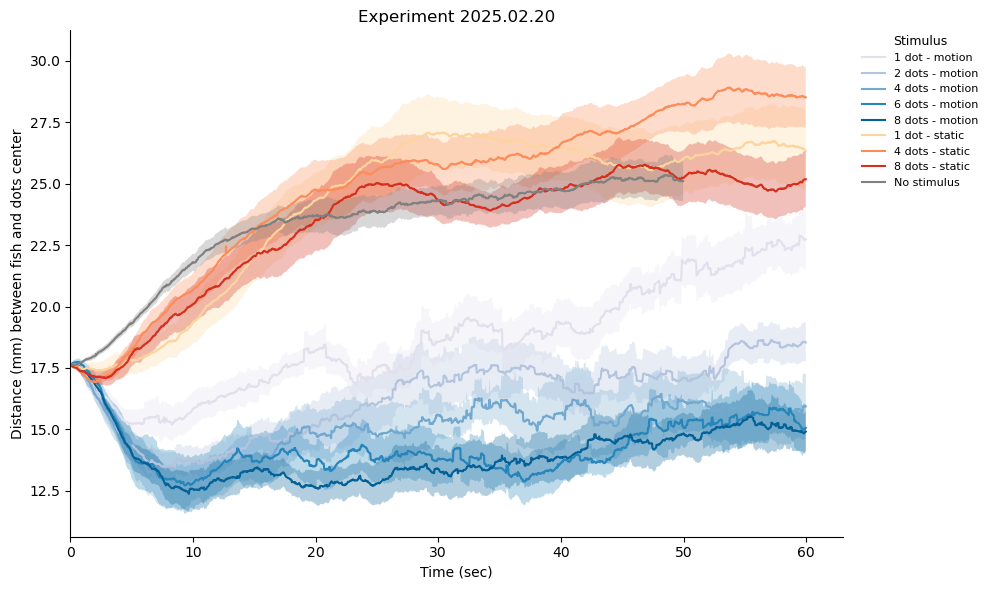

In [36]:
import re
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------
# 1) Stim parsing & helpers
# ---------------------------
def parse_stim(stim):
    """
    'd1s3.5' -> (1, 3.5). Returns (None, None) for non-matching strings.
    """
    m = re.match(r"d(\d+)s([\d\.]+)$", stim)
    if not m:
        return None, None
    return int(m.group(1)), float(m.group(2))

def is_motion(stim):
    d, s = parse_stim(stim)
    return d is not None and s is not None and s != 0.0

def is_static(stim):
    d, s = parse_stim(stim)
    return d is not None and s is not None and s == 0.0

def auto_label(stim):
    if stim == "inter_stim_pause":
        return "No stimulus"
    d, s = parse_stim(stim)
    if d is None:
        return stim
    return f"{d} dot{'s' if d != 1 else ''} - {'static' if s == 0 else 'motion'}"

# Use your order
stimuli_order = ["d1s3.5", "d2s3.5", "d4s3.5", "d6s3.5", "d8s3.5", "d1s0", "d4s0", "d8s0", "inter_stim_pause"]

# ---------------------------
# 2) Build gradient palettes
# ---------------------------
MOTION_CMAP = "PuBu"   # e.g., "PuBu", "Blues", "Purples", "viridis", add "_r" to reverse
STATIC_CMAP = "OrRd"   # e.g., "OrRd", "YlOrRd", "Reds", "magma", add "_r" to reverse

motion_stims = [s for s in stimuli_order if is_motion(s)]
static_stims = [s for s in stimuli_order if is_static(s)]

motion_dots_sorted = sorted({parse_stim(s)[0] for s in motion_stims})
static_dots_sorted = sorted({parse_stim(s)[0] for s in static_stims})

motion_palette = sns.color_palette(MOTION_CMAP, n_colors=len(motion_dots_sorted)) if motion_dots_sorted else []
static_palette = sns.color_palette(STATIC_CMAP, n_colors=len(static_dots_sorted)) if static_dots_sorted else []

# Map each stimulus to the gradient color by rank of its dot count
color_map = {}
dot_to_motion_color = {d: motion_palette[i] for i, d in enumerate(motion_dots_sorted)}
dot_to_static_color = {d: static_palette[i] for i, d in enumerate(static_dots_sorted)}

for s in motion_stims:
    d, _ = parse_stim(s)
    color_map[s] = dot_to_motion_color[d]
for s in static_stims:
    d, _ = parse_stim(s)
    color_map[s] = dot_to_static_color[d]
color_map["inter_stim_pause"] = "gray"

# Optional: if you have a custom label map already, use it; otherwise fall back to auto_label
def get_label(stim):
    try:
        return stim_label_map.get(stim, auto_label(stim))  # uses your existing dict if present
    except NameError:
        return auto_label(stim)

# ---------------------------
# 3) Plot
# ---------------------------
fig, ax = plt.subplots(figsize=(10, 6))

for stim in stimuli_order:
    # Filter data for the current stim across all fish
    stim_data = fish_df_long[(fish_df_long['stimulus'] == stim) &
                             (fish_df_long['dots_out'] < 1)].copy()

    # Convert and time index
    stim_data.loc[:, 'dist_mm'] = stim_data['squareDist_rot'] / PX_TO_MM
    stim_data.loc[:, 'time'] = stim_data['frame_count_stimulus'] / framerate

    # Avg per fish per time (across trials)
    fish_time_avg = stim_data.groupby(['fish_number', 'time'])['dist_mm'].mean().reset_index()

    # Mean ± SEM across fish at each time
    grouped = fish_time_avg.groupby('time')['dist_mm']
    avg = grouped.mean()
    sem = grouped.sem()

    # Color + plot
    color = color_map.get(stim, "gray")
    label = get_label(stim)

    ax.plot(avg.index, avg, label=label, color=color)
    ax.fill_between(avg.index, avg - sem, avg + sem, alpha=0.3, color=color, edgecolor='none')

# Axes styling
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Distance (mm) between fish and dots center')
ax.set_xlim(left=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(f"Experiment {date.name}")

# Legend outside on the right
plt.subplots_adjust(right=0.78)  # leaves room for legend
ax.legend(title="Stimulus", loc="upper left", fontsize=8,
          bbox_to_anchor=(1.02, 1), borderaxespad=0., frameon=False, title_fontsize=9)

plt.tight_layout()
plt.savefig('/Volumes/LAB-MATI/Lausanne/behavior/plots/2025-09-22/distmm_allcond_sqarecenter.pdf', dpi=1200, bbox_inches='tight')
plt.savefig('/Volumes/LAB-MATI/Lausanne/behavior/plots/2025-09-22/distmm_allcond_sqarecenter.png', dpi=1200, bbox_inches='tight')
plt.show()


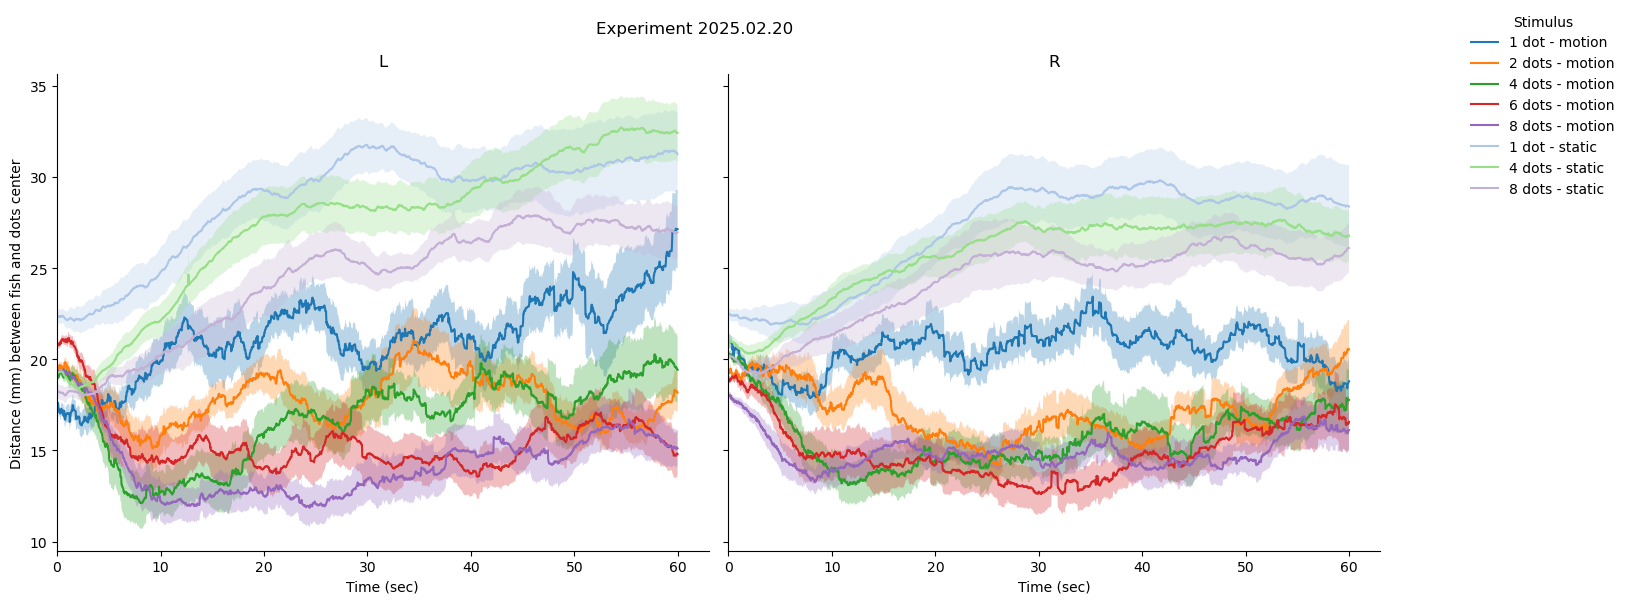

In [149]:
# Create a figure with two subplots: left for stim_side == 'L', right for stim_side == 'R'
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)  # sharey makes Y axis the same

stim_sides = ['L', 'R']

for i, stim_side in enumerate(stim_sides):
    ax = axs[i]

    for stim in stimuli_order:
        if stim != 'inter_stim_pause':
            # Filter data for the current stim and stim_side
            stim_data = fish_df_long[(fish_df_long['stimulus'] == stim) &
                                     (fish_df_long['dots_out'] < 1) &
                                     (fish_df_long['stim_side'] == stim_side)].copy()

            if stim_data.empty:
                continue  # Skip if no data

            # Convert units
            stim_data['dist_mm'] = stim_data['dotsDist'] / PX_TO_MM
            stim_data['time'] = stim_data['frame_count_stimulus'] / framerate
            fish_time_avg = stim_data.groupby(['fish_number', 'time'])['dist_mm'].mean().reset_index()

            # Group by time
            grouped = fish_time_avg.groupby('time')['dist_mm']
            avg_dotDist_per_frame = grouped.mean()
            sem_dotDist_per_frame = grouped.sem()

            # Plot mean + SEM
            color = color_map[stim]
            ax.plot(avg_dotDist_per_frame.index, avg_dotDist_per_frame, label=stim_label_map.get(stim, stim), color=color)
            ax.fill_between(avg_dotDist_per_frame.index,
                            avg_dotDist_per_frame - sem_dotDist_per_frame,
                            avg_dotDist_per_frame + sem_dotDist_per_frame,
                            alpha=0.3, color=color, edgecolor='none')

    # Styling
    ax.set_title(stim_side)
    ax.set_xlabel('Time (sec)')
    ax.set_xlim(left=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Shared Y label
axs[0].set_ylabel('Distance (mm) between fish and dots center')

# Legend (only once, outside the plot)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Stimulus", loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0., frameon=False)
fig.suptitle(f"Experiment {date.name}")

# plt.savefig(path_figures / rf"distmm_allcond_LR.pdf", dpi=1200, bbox_inches='tight')
# plt.savefig(path_figures / rf"distmm_allcond_LR.png", dpi=1200, bbox_inches='tight')

plt.tight_layout()
plt.show()

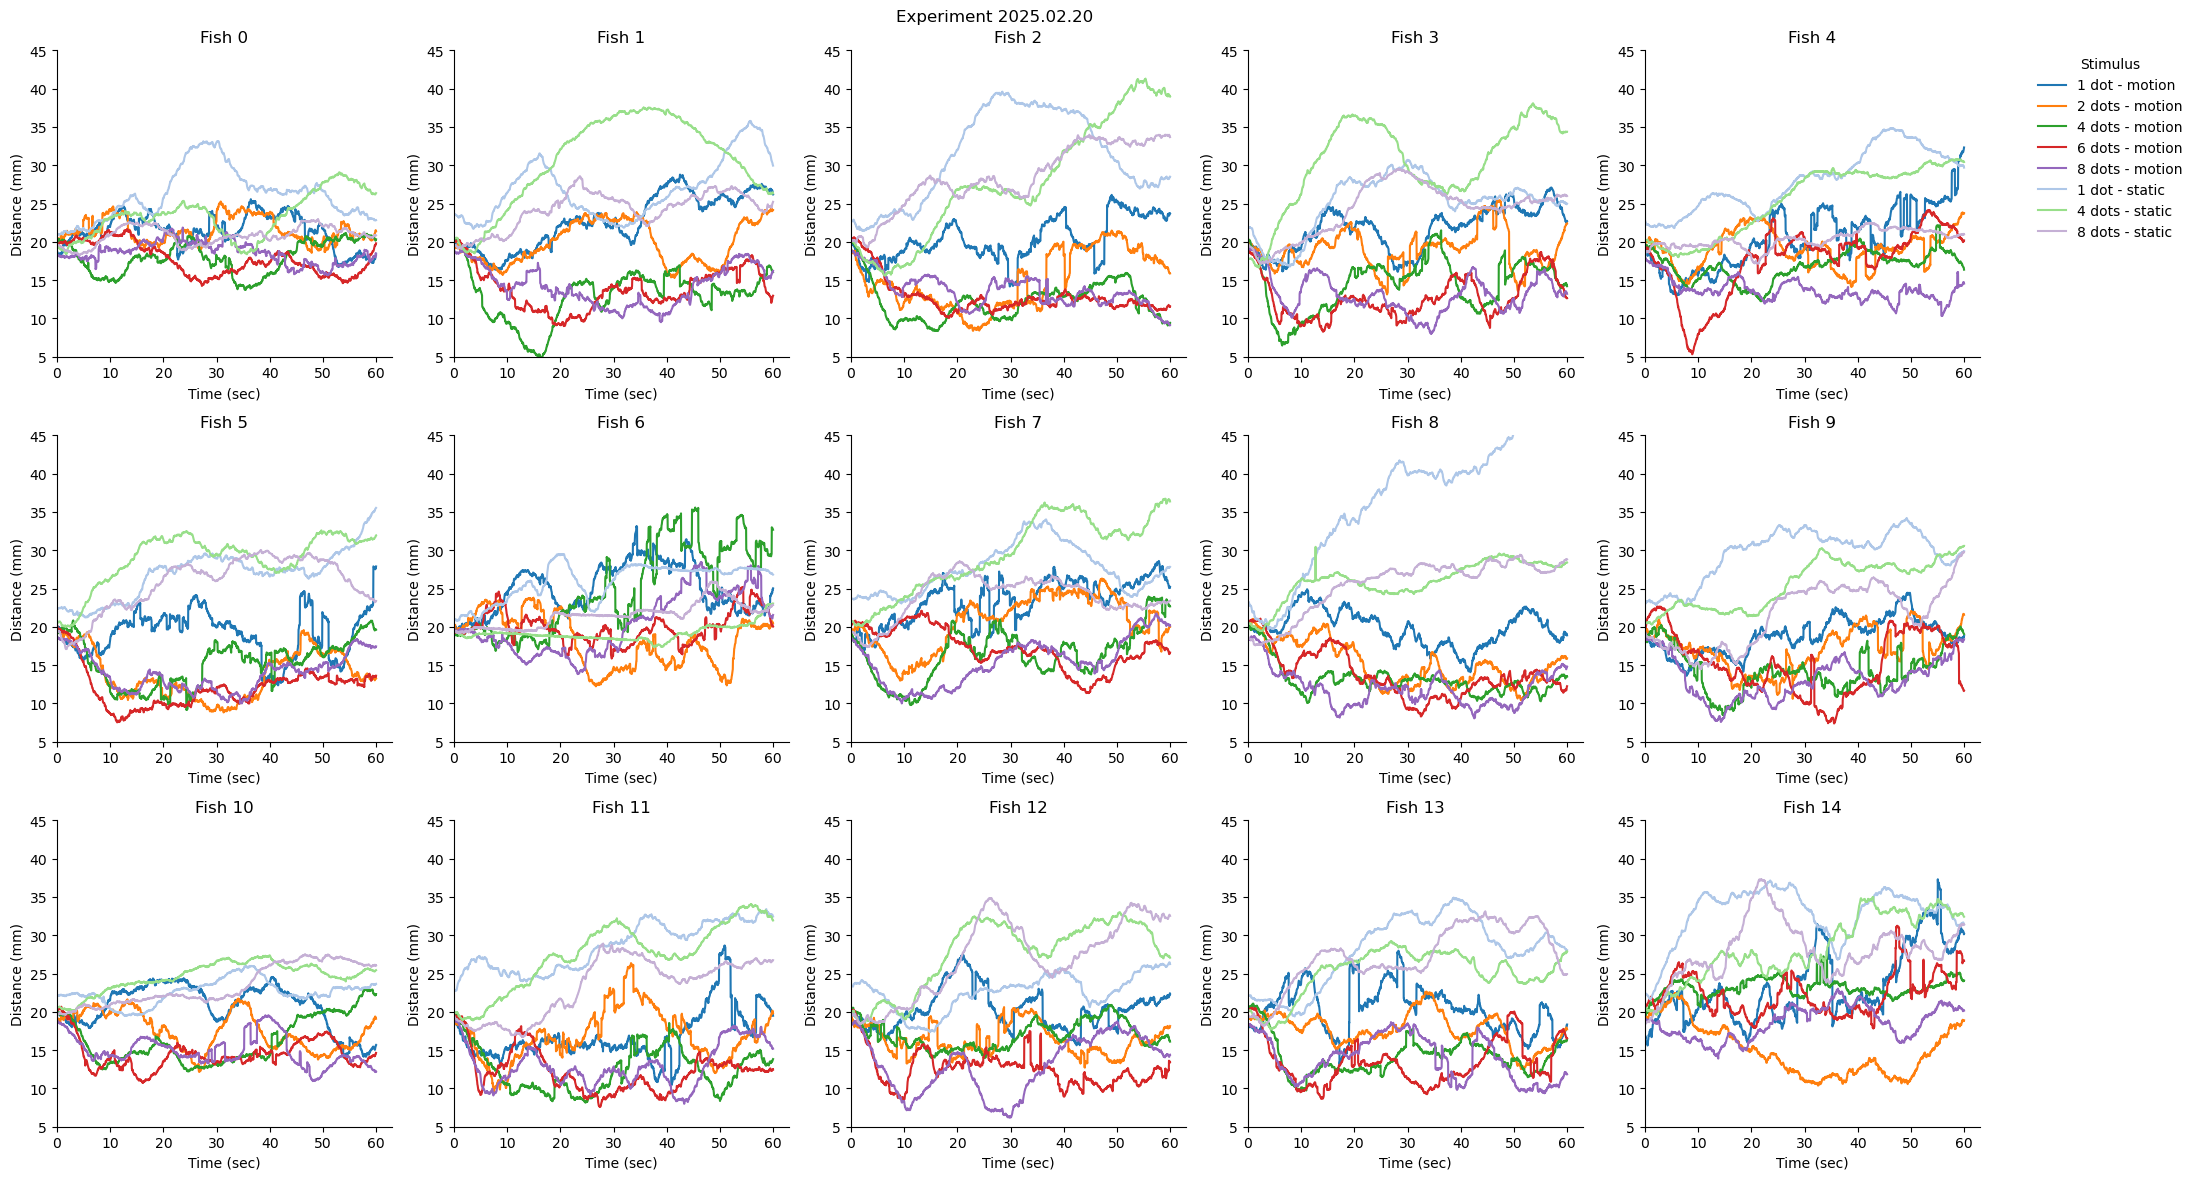

In [150]:
# Create the grid: 3 rows x 5 columns = 15 subplots
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))
axs = axs.flatten()

for fish in range(n_fish):  # assuming fish_number goes from 0 to 14
    ax = axs[fish]

    for stim in stimuli_order:
        if stim != 'inter_stim_pause':
            # Filter for current fish and condition
            stim_data = fish_df_long[(fish_df_long['fish_number'] == fish) &
                                     (fish_df_long['dots_out'] < 1) &
                                     (fish_df_long['stimulus'] == stim)].copy()

            # Convert units
            stim_data['dist_mm'] = stim_data['dotsDist'] / PX_TO_MM
            stim_data['time'] = stim_data['frame_count_stimulus'] / framerate

            # Group by time and get mean
            grouped = stim_data.groupby('time')['dist_mm']
            avg_dotDist_per_frame = grouped.mean()
            sem_dotDist_per_frame = grouped.sem()

            # Plot mean line
            ax.plot(avg_dotDist_per_frame.index, avg_dotDist_per_frame.values, label=stim_label_map.get(stim, stim), color=color_map[stim])

            # # Optional: plot SEM as shaded area
            # ax.fill_between(avg_dotDist_per_frame.index,
            #                 avg_dotDist_per_frame - sem_dotDist_per_frame,
            #                 avg_dotDist_per_frame + sem_dotDist_per_frame,
            #                 color=color_map[condition], alpha=0.2)

            ax.set_ylim(5, 45)

    ax.set_title(f'Fish {fish}')
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Distance (mm)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(left=0)

# One single legend for all plots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title="Stimulus", loc='upper right', bbox_to_anchor=(1.1, 0.95), frameon=False)

fig.suptitle(f"Experiment {date.name}")

# plt.savefig(path_figures / rf"grid_eachfish_distmm_allcond.pdf", dpi=1200, bbox_inches='tight')
# plt.savefig(path_figures / rf"grid_eachfish_distmm_allcond.png", dpi=1200, bbox_inches='tight')

plt.tight_layout()
plt.show()

#### X position over time

In [208]:
df_avg = fish_df_long.copy()
#df_avg = df_avg[df_avg['dots_out'] < 1]
df_avg['frame_group'] = (df_avg['frame_count_stimulus'] // 15) * 15
df_avg['time']=df_avg.frame_group/framerate
df_avg['x_mm']=df_avg.x_rot/PX_TO_MM
df_avg = df_avg[(df_avg['time'] <= 20)]
# df_avg = df_avg.drop(columns=['stimulus'])
df_avg['stim'] = df_avg['stimulus'].astype(str) + "_" + df_avg['stim_side'].astype(str)

In [209]:
s0_left = [c for c in sorted(df_avg['stim'].unique()) if 's0' in c and '_L' in c]
s0_right = [c for c in sorted(df_avg['stim'].unique()) if 's0' in c and '_R' in c]
s0_c = s0_left + s0_right
s3_left = [c for c in sorted(df_avg['stim'].unique()) if 's3' in c and '_L' in c]
s3_right = [c for c in sorted(df_avg['stim'].unique()) if 's3' in c and '_R' in c]
s3_c = s3_left + s3_right
pause_stimuli = ["inter_stim_pause_L", "inter_stim_pause_R"]

# Generate colors
s0_blues = sns.color_palette("RdBu_r", len(s0_right) * 2)[:len(s0_right)]  # Lightest → darkest red
s0_reds = sns.color_palette("RdBu_r", len(s0_left) * 2)[-len(s0_left):]  # Lightest → darkest blue
s3_pinks = sns.color_palette("PiYG", len(s3_left) * 2)[:len(s3_left)]  # Lightest → darkest pink
s3_greens = sns.color_palette("PiYG", len(s3_right) * 2)[-len(s3_right):]  # Lightest → darkest green
pause_colors = ["gray", "dimgray"]

# Create mapping from stim name to color
color_map = {c: col for c, col in zip(s0_left, s0_reds)}
color_map.update({c: col for c, col in zip(s0_right[::-1], s0_blues)})
color_map.update({c: col for c, col in zip(s3_left[::-1], s3_pinks)})
color_map.update({c: col for c, col in zip(s3_right, s3_greens)})
color_map.update({c: col for c in pause_stimuli for col in pause_colors})

# Filter the data for s0 and s3.5 cstim
s0_tmp = df_avg[df_avg['stim'].isin(s0_c)]
s3_tmp = df_avg[df_avg['stim'].isin(s3_c)]

# # Create the color map based on the above order (ensure it's properly defined earlier)
ordered_color_map_s0 = {c: color_map[c] for c in s0_c if c in color_map}
ordered_color_map_s3 = {c: color_map[c] for c in s3_c if c in color_map}

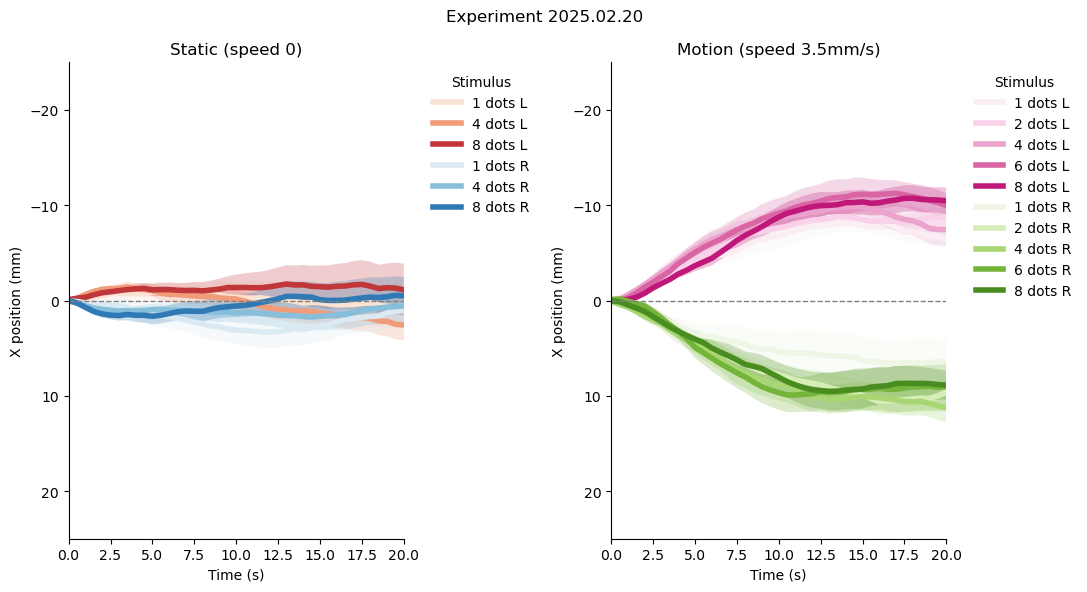

In [213]:
# Create subplots with 1 row and 2 columns (side by side)
fig, axes = plt.subplots(1, 2, figsize=(11, 6))

# Average x position per fish over time
s0_tmp_avg = s0_tmp.groupby(['fish_number', 'time', 'stim'])['x_mm'].mean().reset_index()
s3_tmp_avg = s3_tmp.groupby(['fish_number', 'time', 'stim'])['x_mm'].mean().reset_index()

# Data and titles to loop over
data_stimuli = [(s0_tmp_avg, ordered_color_map_s0, s0_c, 'Static (speed 0)'),
                (s3_tmp_avg, ordered_color_map_s3, s3_c, 'Motion (speed 3.5mm/s)')]

# Loop over each subplot
for ax, (data, color_map, stimulus_list, title) in zip(axes, data_stimuli):
    # Group and compute mean and SEM
    grouped = data.groupby(['stim', 'time'])['x_mm']
    mean_df = grouped.mean().reset_index()
    sem_df = grouped.sem().reset_index()

    # Merge mean and SEM
    merged = mean_df.merge(sem_df, on=['stim', 'time'], suffixes=('_mean', '_sem'))

    # Plot each stimulus
    for stim in stimulus_list:
        stim_data = merged[merged['stim'] == stim]
        if stim_data.empty:
            continue

        x = stim_data['time']
        y = stim_data['x_mm_mean']
        yerr = stim_data['x_mm_sem']
        color = color_map[stim]

        # Plot the mean line
        ax.plot(x, y, label=stim_label_map.get(stim, stim), color=color, linewidth=4)

        # Plot the shaded error area (SEM)
        ax.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.25, edgecolor='none')

    # Styling
    ax.set_title(title)
    ax.set_ylim(25, -25)
    ax.set_xlim(0, 20)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('X position (mm)')
    ax.axhline(0, color='grey', linestyle='--', lw=1)
    # ax.set_xticks(ax.get_xticks()[::2])
    # plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    ordered_handles = [handles[labels.index(s)] for s in stimulus_list if s in labels]
    ordered_labels = [f'{s[1]} dots {s[-1]}' for s in stimulus_list if s in labels]
    ax.legend(ordered_handles, ordered_labels, title="Stimulus", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

# Suptitle and layout
fig.suptitle(f"Experiment {date.name}")
plt.tight_layout()
plt.savefig(path_figures / rf"xpos_allcond.pdf", dpi=1200, bbox_inches='tight')
plt.savefig(path_figures / rf"xpos_allcond.png", dpi=1200, bbox_inches='tight')
plt.show()


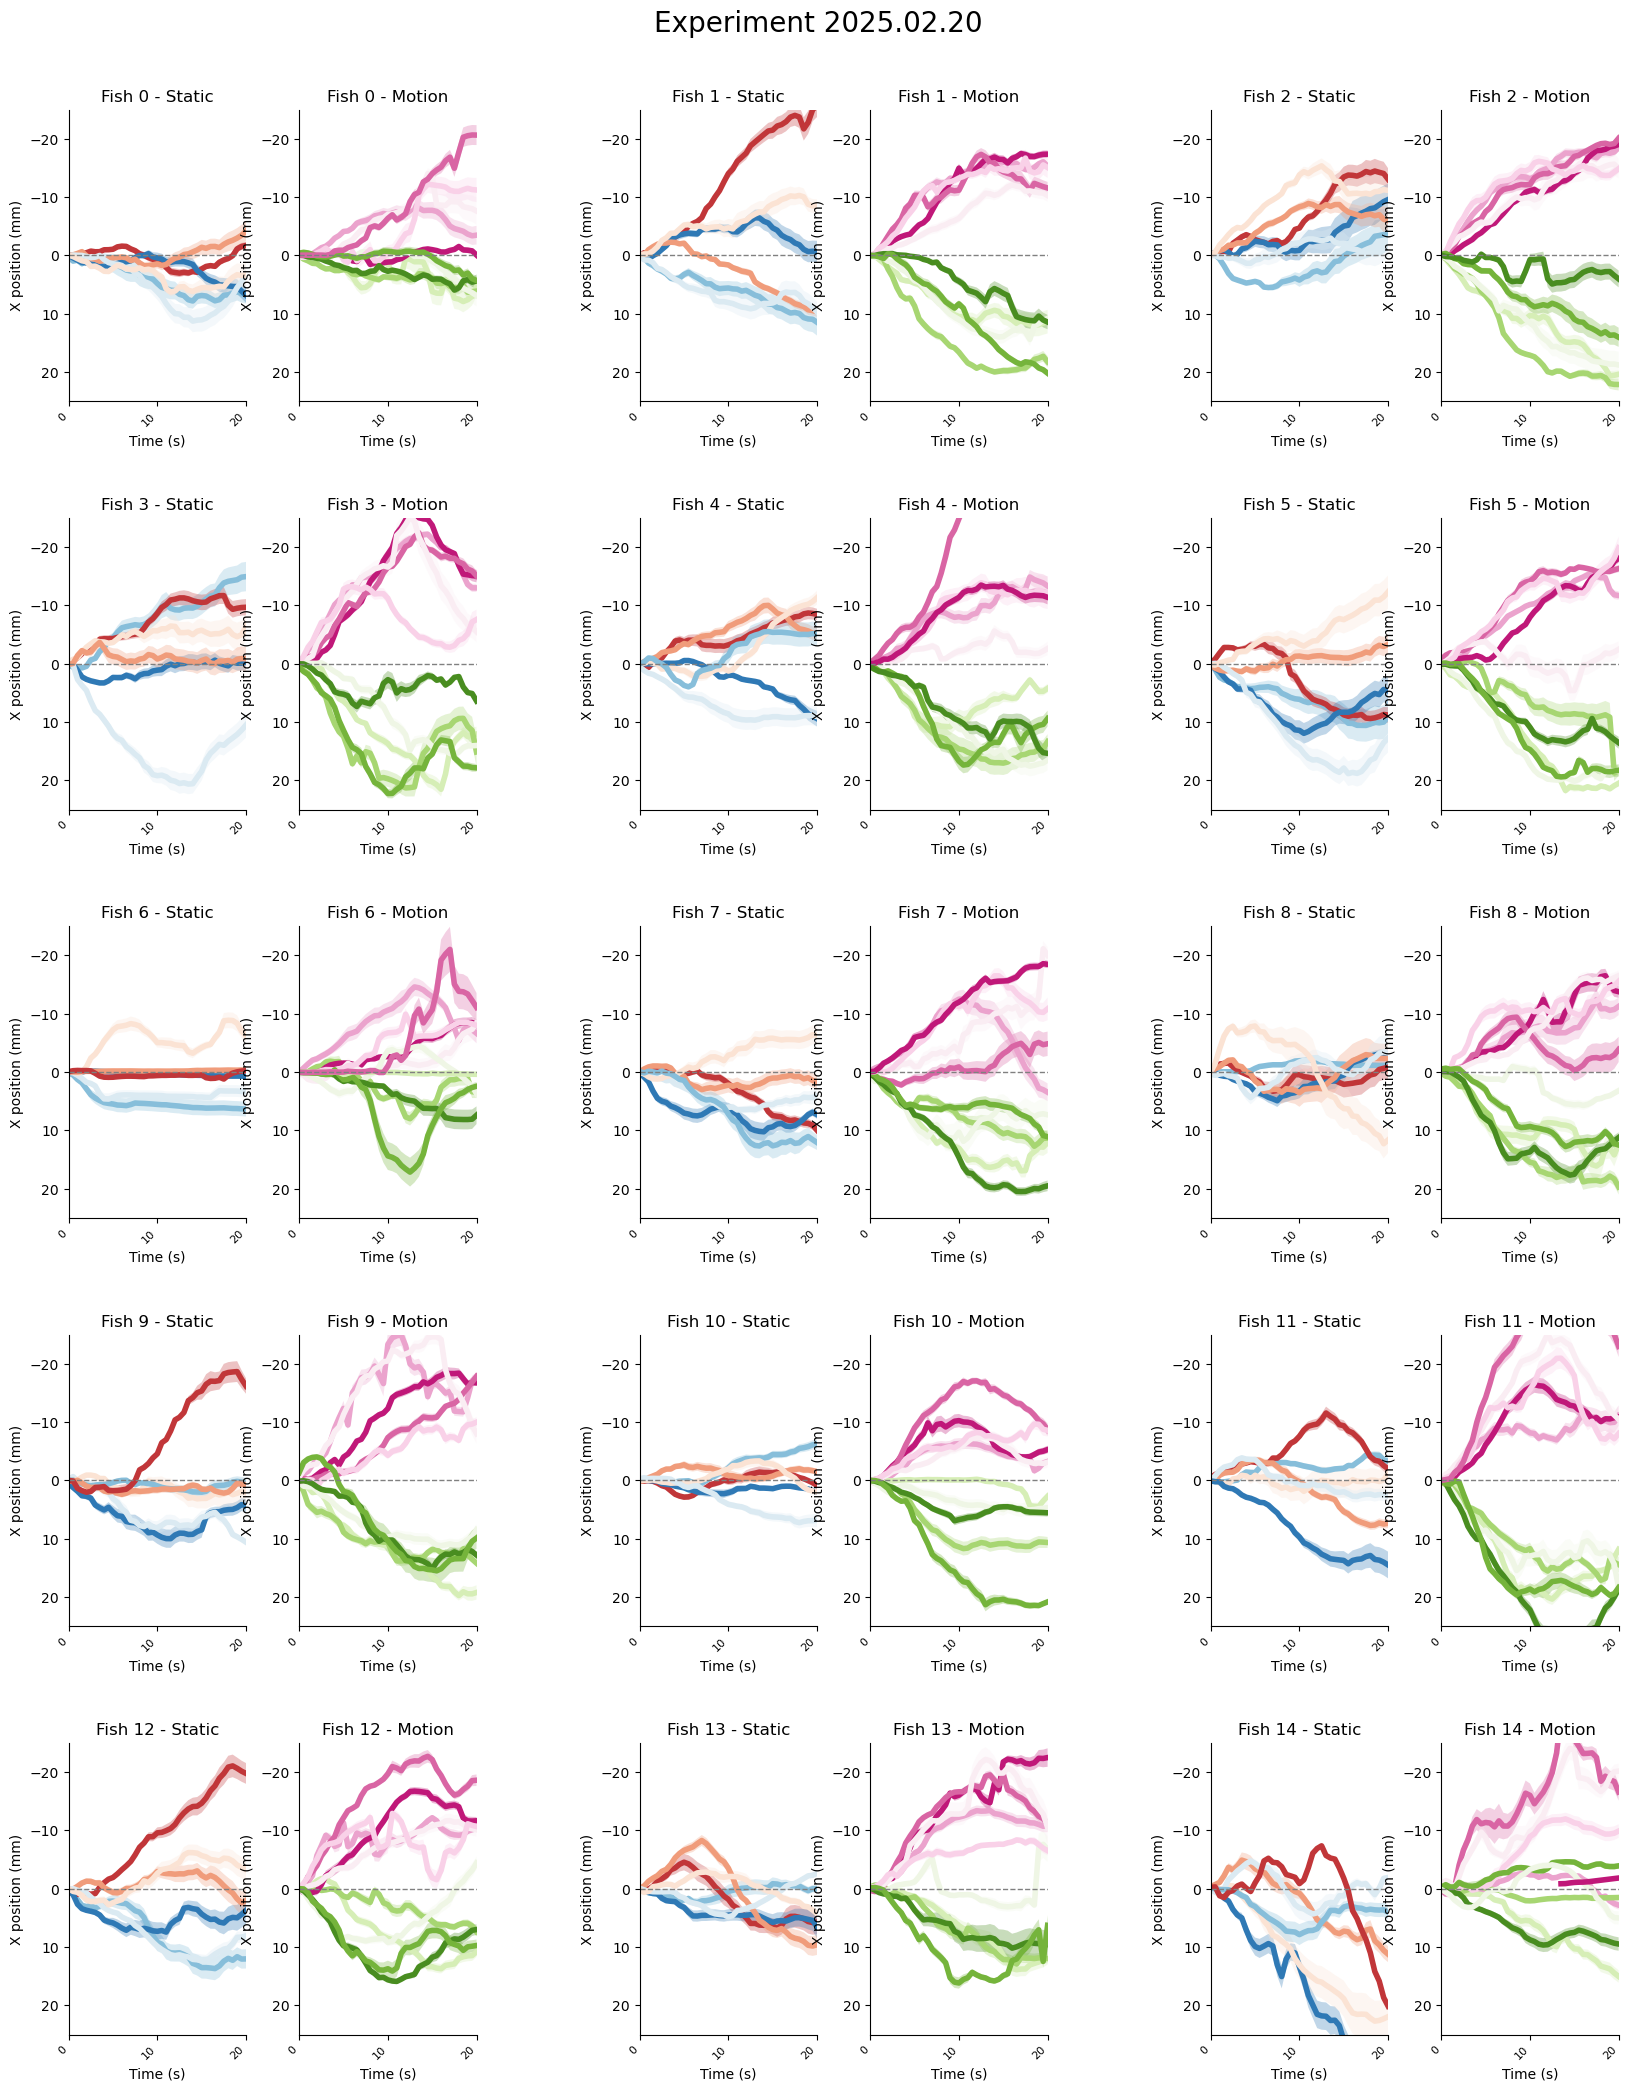

In [217]:
# Create a big figure with 5 rows and 3 columns (15 plots)
fig = plt.figure(figsize=(20, 25))
outer = gridspec.GridSpec(5, 3, wspace=0.4, hspace=0.4)

for f in range(n_fish):  # assume you have a list of 15 fish IDs
    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[f], wspace=0.3)

    # Filter data for this fish
    s0_fish = s0_tmp[(s0_tmp['fish_number'] == f) & (s0_tmp['dots_out'] < 1)]
    s3_fish = s3_tmp[(s3_tmp['fish_number'] == f) & (s3_tmp['dots_out'] < 1)]

    for idx, (data, color_map, title, ax_pos) in enumerate([
        (s0_fish, ordered_color_map_s0, f"Fish {f} - Static", inner[0]),
        (s3_fish, ordered_color_map_s3, f"Fish {f} - Motion", inner[1])
    ]):
        ax = plt.Subplot(fig, ax_pos)

        # Compute mean and SEM
        grouped = data.groupby(['stim', 'time'])['x_mm']
        mean_df = grouped.mean().reset_index()
        sem_df = grouped.sem().reset_index()
        merged = mean_df.merge(sem_df, on=['stim', 'time'], suffixes=('_mean', '_sem'))

        # Plot each stimulus
        for stim in data['stim'].unique():
            stim_data = merged[merged['stim'] == stim]
            if stim_data.empty:
                continue

            x = stim_data['time']
            y = stim_data['x_mm_mean']
            yerr = stim_data['x_mm_sem']
            color = color_map.get(stim, 'black')

            ax.plot(x, y, color=color, label=stim, linewidth=4)
            ax.fill_between(x, y - yerr, y + yerr, color=color, alpha=0.3, edgecolor='none')

        # Plot formatting
        ax.set_title(title)
        ax.set_ylim(25, -25)
        ax.set_xlim(0,20)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('X position (mm)')
        ax.axhline(0, color='grey', linestyle='--', lw=1)
        ax.set_xticks(ax.get_xticks()[::2])
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        fig.add_subplot(ax)

fig.suptitle(f"Experiment {date.name}", fontsize=20, y=0.92)

# Save if needed
plt.savefig(path_figures / rf"grid_eachfish_xpos_allcond.pdf", dpi=1200, bbox_inches='tight')
plt.savefig(path_figures / rf"grid_eachfish_xpos_allcond.png", dpi=1200, bbox_inches='tight')

plt.show()

#### Dots out

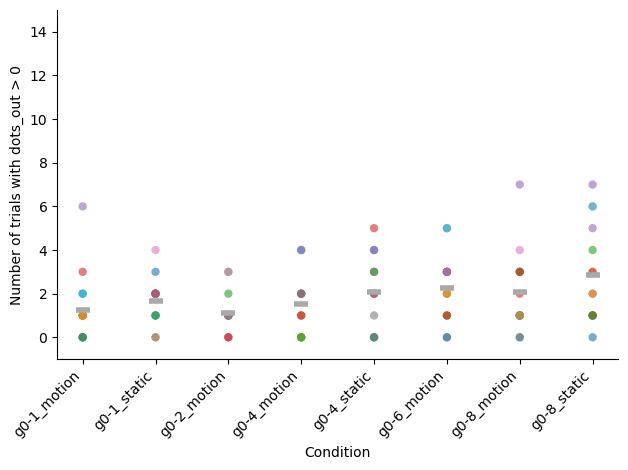

In [21]:
# 1. Filter to frame_count_stimulus == 0
df0 = fish_df_long[(fish_df_long['frame_count_stimulus'] == 0) & (fish_df_long['condition_grouped'] != 'inter_stim_pause')].copy()

# 2. For each trial, flag if either side has dots_out > 0
trial_flags = (df0.groupby(['fish_number', 'condition_grouped', 'trial_id'])['dots_out'].max().gt(0).reset_index(name='has_dots_out'))

# 3. Count trials with dots_out per fish and condition
summary = (trial_flags.groupby(['fish_number', 'condition_grouped']).agg(total_trials = ('trial_id', 'nunique'),
                                                                         trials_dots_out=('has_dots_out', 'sum')).reset_index())

summary['prop_with_dots'] = (summary['trials_dots_out'] / summary['total_trials'])

# 4. Compute average per condition
avg = summary.groupby('condition_grouped')['trials_dots_out'].mean().reset_index()

# 5. Plot
conditions = sorted(summary['condition_grouped'].unique())
x_pos = {cond: idx for idx, cond in enumerate(conditions)}

fig, ax = plt.subplots()

# Plot each fish
for fish in summary['fish_number'].unique():
    df_f = summary[summary['fish_number'] == fish]
    xs = [x_pos[c] for c in df_f['condition_grouped']]
    ys = df_f['trials_dots_out']
    ax.scatter(xs, ys, alpha=.6, edgecolors='none')

# Plot average
xs_avg = [x_pos[c] for c in avg['condition_grouped']]
ys_avg = avg['trials_dots_out']
ax.scatter(xs_avg, ys_avg, marker='_', s=100,linewidths=4, color='darkgray')

ax.set_xticks(list(x_pos.values()))
ax.set_xticklabels(list(x_pos.keys()), rotation=45, ha='right')
ax.set_xlabel('Condition')
ax.set_ylabel('Number of trials with dots_out > 0')
ax.set_ylim(-1, 15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

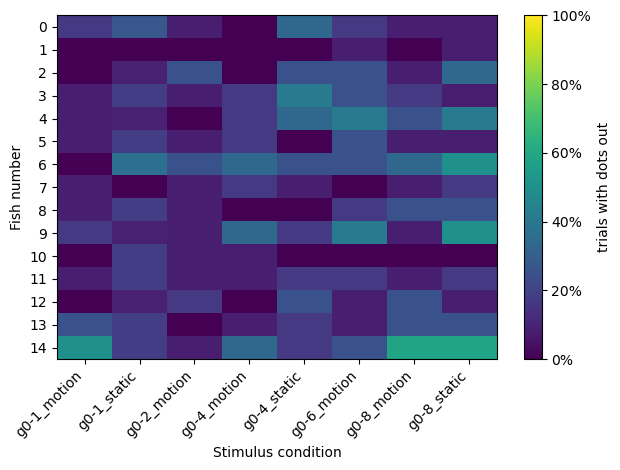

In [31]:
plt.show()
from matplotlib.ticker import PercentFormatter

pivot = summary.pivot(index='fish_number', columns='condition_grouped', values='prop_with_dots')

fig, ax = plt.subplots()
im = ax.imshow(pivot, aspect='auto', vmin=0, vmax=1)

ax.set_xticks(np.arange(pivot.shape[1]))
ax.set_xticklabels(pivot.columns, rotation=45, ha='right')

ax.set_yticks(np.arange(pivot.shape[0]))
ax.set_yticklabels(pivot.index)

plt.colorbar(im, ax=ax, label='trials with dots out', format=PercentFormatter(1.0))
ax.set_xlabel('Stimulus condition')
ax.set_ylabel('Fish number')
plt.tight_layout()
plt.show()

#### Plot choice probability

In [78]:
df_choice = fish_df_long[fish_df_long['dots_out'] < 1].loc[(fish_df_long['first_choice'] > 0)].groupby(['fish_number','condition_grouped', 'stimulus']).size().reset_index(name='count').copy()
# First, calculate the total choices per fish and condition
total_counts = df_choice.groupby(['fish_number', 'condition_grouped'])['count'].transform('sum')

# Create a new column with the probability of choosing that stimulus
df_choice['choice_probability'] = df_choice['count'] / total_counts
#df_choice['stim_group'] = df_choice['stimulus'].str.extract(r'(d[24])')

TypeError: '>' not supported between instances of 'str' and 'int'

In [ ]:
# Get the unique stimuli in this filtered data
unique_stimuli = df_choice['stimulus'].unique()
n_stimuli = len(unique_stimuli)
condition_order = sorted(df_choice['condition_grouped'].unique())  # Sorted for consistent x-axis positions
use_dodge = n_stimuli > 1
dodge_value = 0.532 if use_dodge else False
palette = sns.color_palette("Set2", n_colors=n_stimuli)

# Define dodge only if multiple hue levels (stimuli)
use_dodge = n_stimuli > 1
dodge_value = 0.532 if use_dodge else False

# Consistent palette
palette = sns.color_palette("Set2", n_colors=n_stimuli)

plt.figure(figsize=(10, 6))
# Add alternating background shading
for i in range(len(condition_order)):
    color = 'lightgray' if i % 2 == 0 else 'white'
    plt.axvspan(i - 0.5, i + 0.5, color=color, alpha=0.3, zorder=0)

# Stripplot (background layer)
sns.stripplot(data=df_choice,x='condition_grouped',y='choice_probability',hue='stimulus',dodge=use_dodge,linewidth=0,edgecolor=None,alpha=0.5,palette=palette)

# Pointplot (top layer)
sns.pointplot(data=df_choice,x='condition_grouped',y='choice_probability',hue='stimulus',dodge=dodge_value,markers='o',linestyles='',palette=palette,errorbar='se')

# Vertical dashed lines between condition groups
for i in range(len(condition_order) - 1):
    plt.axvline(x=i + 0.5, color='lightgray', linestyle='--', linewidth=0.7)

# Plot formatting
plt.axhline(y=0.5, color='red', linestyle='--', label='50% Threshold')
plt.title('Choice Probabilities (g2-x Conditions)')
plt.ylabel('Probability of Choosing 2 dots')
plt.xlabel('Condition Group')
plt.xticks(rotation=45)
plt.ylim(0.1, 0.9)

# Clean up legend (remove duplicates)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Stimulus', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
left_time = (trial_group['x_rot'] < 0).sum()
right_time = (trial_group['x_rot'] > 0).sum()
total_time = len(trial_group)

choice_index = (right_time - left_time) / total_time

In [77]:
tmp_df = fish_df_long[(fish_df_long['dots_out'] < 1) & (fish_df_long['condition'] != 'inter_stim_pause')].copy()
(tmp_df.groupby(['fish_number','stimulus_block_id'])['x_rot'] < 0).sum()

TypeError: '<' not supported between instances of 'SeriesGroupBy' and 'int'

In [ ]:
# Step 1: Create a new boolean column indicating if x_rot is negative
tmp_df['xrot_left'] = tmp_df['x_rot'] < 0

# Step 2: Group and sum the boolean values (True = 1, False = 0)
neg_xrot_counts = tmp_df.groupby(['fish_number', 'stimulus_block_id'])['xrot_left'].sum()

 ### Bout analysis

In [120]:
# transform in absolute coord
stimuli_bout_df['d0_x'] = stimuli_bout_df['d0_x'].copy() * PX_TO_MM + avgROIRadius
stimuli_bout_df['d0_y'] = stimuli_bout_df['d0_y'].copy() * PX_TO_MM + avgROIRadius

#ivert y axis and fish ori to ccw
bout_df, stimuli_bout_df = an.transform_coordinates(bout_df, stimuli_bout_df, roi_df)

In [121]:
bout_df['frame'] = bout_df.reset_index().index

x_cols = [col for col in bout_df.columns if '_x' in col]
y_cols = [col for col in bout_df.columns if '_y' in col]
ori_cols = [col for col in bout_df.columns if '_ori' in col]

#transform to long
bout_df_long = an.melt_bout_df(bout_df, x_cols, y_cols, ori_cols)

In [122]:
# Shift coordinates
min_shift = 2
to_shift = 60 * framerate * min_shift
bout_df_long = an.shift_coordinates(bout_df_long, to_shift, framerate)

# Shuffle coordinates
bout_df_long = an.shuffle_coordinates(bout_df_long)

#add dot trajectory
bout_df_long['dot_x'] = np.tile(stimuli_bout_df['d0_x'].values, n_fish)
bout_df_long['dot_y'] = np.tile(stimuli_bout_df['d0_y'].values, n_fish)

#compute distance
bout_df_long['dist_original'] = an.euclidean_distance(bout_df_long.x, bout_df_long.y, bout_df_long.dot_x, bout_df_long.dot_y)
bout_df_long['dist_shifted'] = an.euclidean_distance(bout_df_long.x_shift, bout_df_long.y_shift, bout_df_long.dot_x, bout_df_long.dot_y)
bout_df_long['dist_shuffled'] = an.euclidean_distance(bout_df_long.x_shuffled, bout_df_long.y_shuffled, bout_df_long.dot_x, bout_df_long.dot_y)

### Plots

(0.0, 400.0)

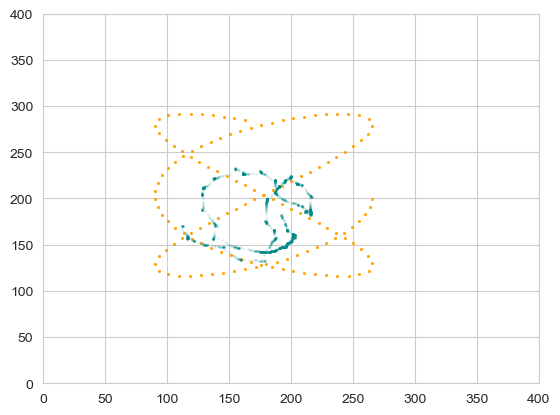

In [124]:
min_visualize = int(1.5*60*framerate)
plt.scatter(stimuli_bout_df.iloc[:min_visualize]['d0_x'], stimuli_bout_df.iloc[:min_visualize]['d0_y'], alpha=.1, s=1, color='orange')
plt.scatter(bout_df.iloc[:min_visualize]['f1_x'], bout_df.iloc[:min_visualize]['f1_y'], alpha=.1, s=.8, color='darkcyan')
plt.xlim(0, 400)
plt.ylim(0, 400)

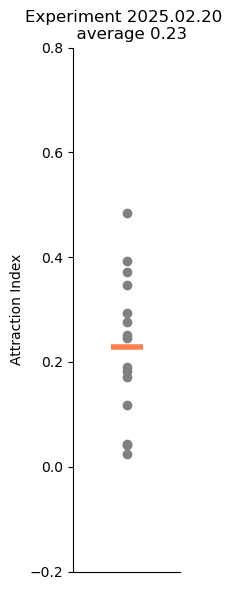

In [127]:
# Group by fish_number and calculate the average distances.
grouped = bout_df_long.groupby('fish_number').agg(
    avg_distance_original=('dist_original', 'mean'),
    avg_distance_shifted=('dist_shifted', 'mean')
).reset_index()

# Calculate the attraction index for each fish.
grouped['attraction_index'] = (
    (grouped['avg_distance_shifted'] - grouped['avg_distance_original'])
    / grouped['avg_distance_shifted']
)

grouped['condition'] = 'bout'

# Calculate the overall average attraction index.
overall_avg_attraction_index = grouped['attraction_index'].mean()

# Plotting
fig, ax = plt.subplots(figsize=(2,6))
ax.scatter(grouped['condition'], grouped['attraction_index'], label='Fish Attraction Index', color='grey')
# plt.axhline(y=overall_avg_attraction_index, color='red', linestyle='--',
#             label=f'Overall Average = {overall_avg_attraction_index:.2f}')

ax.scatter(grouped['condition'][0], overall_avg_attraction_index, color='coral', s=500, marker='_', label="Mean", linewidths=4)
ax.set_title(f'Experiment {date.name} \n  '
             f'average {overall_avg_attraction_index:.2f}')
ax.set_ylabel('Attraction Index')
ax.set_ylim(-0.2, 0.8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# # Adjust layout
plt.tight_layout()

# plt.savefig(path_figures / f"bout_attraction.pdf", dpi=1200, bbox_inches='tight')
# plt.savefig(path_figures / f"bout_attraction.png", dpi=1200, bbox_inches='tight')
plt.show()